# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...          PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...       774706.000000   
mean                2.874167          3.075121      ...            2.253330   
std                 1.486731          1.353248      ...            0.972008   
min                 1.000000          1.000000      ...            0.000000   
25%                 2.000000          2.000000      ...            1.000000   
50%                 3.000000          3.000000      ...            2.000000   
75%                 4.000000          4.000000      ...            3.000000   
max                 5.000000          5.000000      ...            4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

In [5]:
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [8]:
feat_info.describe()

attribute information_level     type missing_or_unknown
count               85                85       85                 85
unique              85                 9        5                  9
top     WOHNDAUER_2008            person  ordinal               [-1]
freq                 1                43       49                 26

In [9]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [10]:
# find out the different kind of encodings
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Identify missing or unknown data values and convert them to NaNs.

class DataWrangler:
    
    def __init__(self, data, featInfo):
        self.genPopulationData = data.copy()
        self.featInfo = featInfo
        self.nullsPercentBefore = None
        self.nullsPercentAfter = None
        
    # Scrub all missing or unknown data to NaN    
    def convertMissingToNaN(self, initial=True):
        # Convert to NaNs using our new self.missingDataEncode map
        if not initial: return self.deltas
        print("Please wait. This can take a while...")    
        result = dict()
        for col in self.missingDataEncode.keys():
            nans_before = self.genPopulationData[col].isnull().sum()
            self.genPopulationData.loc[self.genPopulationData[col].isin(self.missingDataEncode[col]), col] = np.nan
            nans_after = self.genPopulationData[col].isnull().sum()
            if nans_after != nans_before:
                result[col] = [nans_before, nans_after]
        self.deltas =pd.DataFrame.from_dict(result)
        return self.deltas
    
    def categorizeMissingData(self):
        if self.nullsPercentAfter is None: 
            print("Error: run and load the data first.")
            return None
        
        # Merge feature info with nan percentage data
        nan_perc_df = pd.DataFrame(self.nullsPercentAfter, columns=['nan_percent'])
        self.featNan = (self.featInfo.merge(nan_perc_df, left_on='attribute', \
                                            right_index=True).drop(columns='missing_or_unknown', axis=1))

        # Split the data into three categories:
        # High percentage of nans (>20%)
        # Moderate percentage of nans (5-20%)
        # Low percentage of nans (0-5%)
        # No nans
        self.featNan['nan_category'] = pd.cut(self.featNan.nan_percent, bins=[-np.inf, 0, 10, 20, np.inf], \
                                              labels=['zero', 'low', 'moderate', 'high'])
        return self.featNan
    
    def printPercentNullsBefore(self, numRows=20):    
        # find out the different kind of encodings before processing
        if self.nullsPercentBefore is None:
            self.nullsPercentBefore = (self.genPopulationData.isnull().mean() * 100).sort_values(ascending=False)
        print(self.nullsPercentBefore[:numRows])

    def printPercentNullsAfter(self, numRows=20):    
    
        if self.nullsPercentAfter is None:
            self.nullsPercentAfter = (self.genPopulationData.isnull().mean() * 100).sort_values(ascending=False)
        print(self.nullsPercentAfter[:numRows])
        
    def printPreprocessedRowsWithNoNaNs(self):
        #How many rows don't have nans before preprocessing?
        print(f'Number of rows that have no NaNs: {self.nullsPercentBefore[self.nullsPercentBefore == 0].shape[0]}')
        
        nanPercent = round(self.genPopulationData.isnull().sum().sum() / np.product(self.genPopulationData.shape) * 100, 2)
        print(f"Total percentage of Nans: {nanPercent}%")
    
    def printProcessedRowsWithNoNaNs(self):
        #How many rows don't have nans before preprocessing?
        print(f'Number of rows that have no NaNs: {self.nullsPercentAfter[self.nullsPercentAfter == 0].shape[0]}')
        
        nanPercent = round(self.genPopulationData.isnull().sum().sum() / np.product(self.genPopulationData.shape) * 100, 2)
        print(f"Total percentage of Nans: {nanPercent}%")
        
    '''Take an array as input and draw a histogram with a boxplot above it'''    
    def plotHistogram(self, x_label='Proportion of missing values', y_label='% of features', bin_incr=0.05, x=None):
        if x is None:
            x=self.nullsPercentBefore/100           
                
        fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={ "height_ratios": (.15, .85)}, figsize=(14, 6))
        sns.boxplot(x, ax=ax_box)
        bins = np.arange(0, x.max() + bin_incr, bin_incr)
        x.hist(grid=False, bins=bins)
        
        ax_box.set(yticks=[])
        ax_hist.set_ylabel(y_label)
        ax_hist.set_xlabel(x_label)
        sns.despine(ax=ax_hist)
        sns.despine(ax=ax_box, left=True)

    '''Takes the column with the missing value encodings and converts to list, specially processing the casses where X or  
       XX is in the encodings'''
    
    def xOrXXToListLambda(self, s):
        if 'XX' in s:
            if len(s) == 4:
                return [s[1:-1]]
            else:
                return [-1, 'XX']
        elif 'X' in s:
            return [-1, 'X']
        else:
            return eval(s) if type(s) == str or type(s) == bytes else s
        
    def xOrXXToList(self):
        self.featInfo.missing_or_unknown = self.featInfo.missing_or_unknown.apply(self.xOrXXToListLambda)
        return self.featInfo   

    ''' Create a dictionary to map column names to missing data encodings'''
    def encodeMissingData(self):
        self.missingDataEncode = dict(zip(self.featInfo.attribute, self.featInfo.missing_or_unknown))
        return self.missingDataEncode
    
    def doCountPlotOfMissingValues(self):
        
        if self.featNan is None:
            print("Error: get the feature and NaN mapping first before running this.")
            return None
        
        fig, ax1 = plt.subplots(figsize=(14,8))
        order = ['person', 'household', 'building', 'postcode', 'community',
           'microcell_rr3', 'microcell_rr4', 'region_rr1', 'macrocell_plz8']
        hue_order = ['zero', 'low', 'moderate', 'high']
        sns.countplot(data=self.featNan,
                  x='information_level',
                  hue='nan_category',
                  order=order,
                  hue_order=hue_order,
                  ax=ax1)
        plt.legend(loc='upper right')
        sns.despine(ax=ax1)
        
    def dropOutliers(self):
        if self.genPopulationData is None:
            print('Error: load data first before running this method')
            return None
        featureToRemove = self.featNan[self.featNan.nan_category == 'high'].attribute             
        print(f"Features to remove: {featureToRemove}")
        self.genPopulationData = self.genPopulationData.drop(columns=featureToRemove, axis=1)
        print(f"New Shape after Dropping Outliers: {self.genPopulationData.shape}")

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

KK_KUNDENTYP        65.596749
KBA05_ANTG1         14.959701
KBA05_ANTG2         14.959701
KBA05_ANTG3         14.959701
KBA05_ANTG4         14.959701
KBA05_BAUMAX        14.959701
KBA05_GBZ           14.959701
MOBI_REGIO          14.959701
REGIOTYP            13.598872
KKK                 13.598872
PLZ8_ANTG3          13.073637
PLZ8_ANTG1          13.073637
PLZ8_GBZ            13.073637
PLZ8_ANTG2          13.073637
PLZ8_HHZ            13.073637
PLZ8_BAUMAX         13.073637
PLZ8_ANTG4          13.073637
W_KEIT_KIND_HH      12.073549
KBA13_ANZAHL_PKW    11.871354
CAMEO_INTL_2015     11.106000
dtype: float64
Number of rows that have no NaNs: 32
Total percentage of Nans: 6.46%


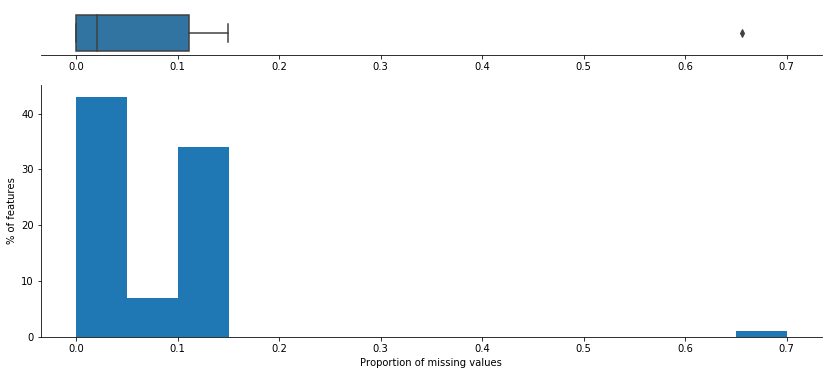

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
dw = DataWrangler(azdias, feat_info)
dw.printPercentNullsBefore()
dw.printPreprocessedRowsWithNoNaNs()
dw.plotHistogram()

In [13]:
# check for XX type
feat_info[feat_info.missing_or_unknown == '[XX]']


attribute information_level         type missing_or_unknown
58  CAMEO_DEU_2015     microcell_rr4  categorical               [XX]

In [14]:
# do the cleaning of the feat_info data dictionary
dw.xOrXXToList()[50:70]

attribute information_level         type missing_or_unknown
50  ANZ_HAUSHALTE_AKTIV          building      numeric                [0]
51         ANZ_HH_TITEL          building      numeric                 []
52          GEBAEUDETYP          building  categorical            [-1, 0]
53          KONSUMNAEHE          building      ordinal                 []
54     MIN_GEBAEUDEJAHR          building      numeric                [0]
55          OST_WEST_KZ          building  categorical               [-1]
56             WOHNLAGE          building        mixed               [-1]
57      CAMEO_DEUG_2015     microcell_rr4  categorical            [-1, X]
58       CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
59      CAMEO_INTL_2015     microcell_rr4        mixed           [-1, XX]
60          KBA05_ANTG1     microcell_rr3      ordinal               [-1]
61          KBA05_ANTG2     microcell_rr3      ordinal               [-1]
62          KBA05_ANTG3     microcell_rr3      ordinal               [-1]
63          KBA05_ANTG4     microcell_rr3      ordinal               [-1]
64         KBA05_BAUMAX     microcell_rr3        mixed            [-1, 0]
65            KBA05_GBZ     microcell_rr3      ordinal            [-1, 0]
66             BALLRAUM          postcode      ordinal               [-1]
67             EWDICHTE          postcode      ordinal               [-1]
68           INNENSTADT          postcode      ordinal               [-1]
69   GEBAEUDETYP_RASTER        region_rr1      ordinal                 []

In [15]:
# Create a dictionary of column names to missing data encodings
mdeDict = dw.encodeMissingData()
# test
print(f"mdeDict['AGER_TYP'] = {mdeDict['AGER_TYP']}")
print(f"mdeDict['CAMEO_DEU_2015' = {mdeDict['CAMEO_DEU_2015']}")

mdeDict['AGER_TYP'] = [-1, 0]
mdeDict['CAMEO_DEU_2015' = ['XX']


In [16]:

dw.convertMissingToNaN()


Please wait. This can take a while...


AGER_TYP  ALTERSKATEGORIE_GROB  GEBURTSJAHR  HEALTH_TYP  \
0         0                     0            0           0   
1    685843                  2881       392318      111196   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
0                 4854                 4854             4854             4854   
1                97632                94572            77792            77792   

   NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE    ...     ANZ_HAUSHALTE_AKTIV  \
0                 0                      0    ...                   93148   
1            108315                 108164    ...                   99611   

   CAMEO_DEUG_2015  CAMEO_DEU_2015  CAMEO_INTL_2015  KBA05_BAUMAX     KKK  \
0            98979           98979            98979        133324  121196   
1            99352           99352            99352        476524  158064   

   REGIOTYP  ARBEIT  ORTSGR_KLS9  RELAT_AB  
0    121196   97216        97216     97216  
1    158064   97375        97274     97375  

[2 rows x 25 columns]

***Legend***:  <br>
        <li>**Row 0** - Number of missing/NaNs before conversion </li>
        <li>**Row 1** - Number of missing/NaNs after conversion</li>

In [17]:
# Investigate patterns in the amount of missing data in each column.
dw.printPercentNullsAfter()

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
REGIOTYP          17.735668
KKK               17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG4       14.959701
KBA05_GBZ         14.959701
MOBI_REGIO        14.959701
KBA05_ANTG1       14.959701
KBA05_ANTG2       14.959701
KBA05_ANTG3       14.959701
PLZ8_GBZ          13.073637
PLZ8_HHZ          13.073637
PLZ8_BAUMAX       13.073637
PLZ8_ANTG4        13.073637
PLZ8_ANTG1        13.073637
dtype: float64


In [18]:
# How many rows with no NaNs post-processing
dw.printProcessedRowsWithNoNaNs()

Number of rows that have no NaNs: 24
Total percentage of Nans: 11.05%


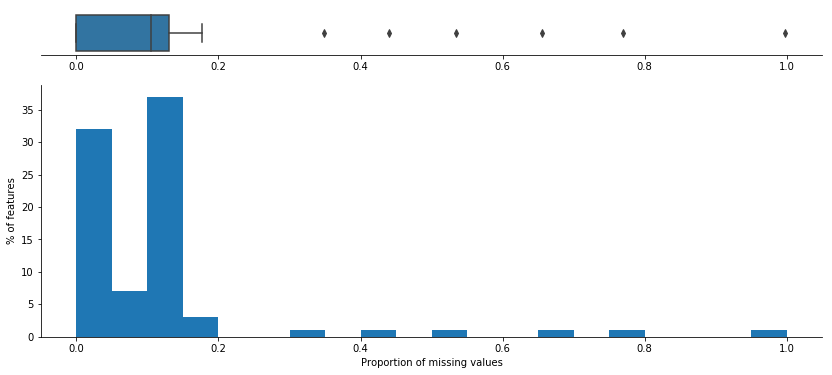

In [19]:
# Histogram post-processing
dw.plotHistogram(x=dw.nullsPercentAfter/100)

In [20]:
# The majority of features have less than 20% missing values. 
# There are six features with a considerably higher number of missing values.
highNan = dw.nullsPercentAfter[dw.nullsPercentAfter > 20]
highNan

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

In [21]:
# Group the data in 4 groups: high % of NaNs  (> 20%)
#                             medium % of NaNs (5% - 20%)
#                             low % of NaNs (0 - 5%)
#                             zero NaNs (0)
dw.categorizeMissingData().head()

attribute information_level         type  nan_percent  \
0              AGER_TYP            person  categorical    76.955435   
1  ALTERSKATEGORIE_GROB            person      ordinal     0.323264   
2             ANREDE_KZ            person  categorical     0.000000   
3         CJT_GESAMTTYP            person  categorical     0.544646   
4     FINANZ_MINIMALIST            person      ordinal     0.000000   

  nan_category  
0         high  
1          low  
2         zero  
3          low  
4         zero

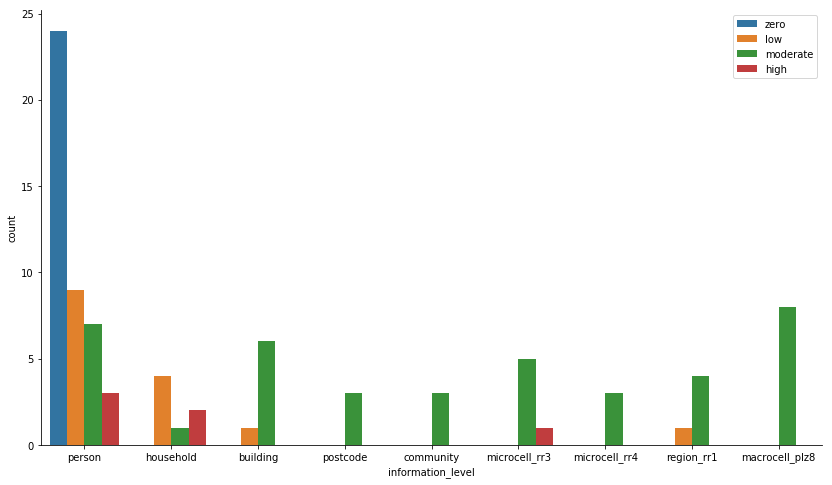

In [22]:
# Do a SwarmPlot so we can visualize the data further
dw.doCountPlotOfMissingValues()


In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# The clear outliers are the data with high number of NaNs
dw.dropOutliers()


Features to remove: 0         AGER_TYP
11     GEBURTSJAHR
40        TITEL_KZ
43        ALTER_HH
47    KK_KUNDENTYP
64    KBA05_BAUMAX
Name: attribute, dtype: object
New Shape after Dropping Outliers: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

If you look at the histogram plots that I created, the majority of features have less than 20% missing values. There are six features with a considerably higher number of missing values: AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, and KBA05_BAUMAX with TITEL_KZ gaining 99% of its data with nulls. Outliers like these 6 features slow the processing with little to gain so I decided to remove these 6 columns from the dataset. 

<ul><li><b>TITEL_KZ</b>: Academic title flag (1: Dr., 4: Prof. Dr., 5: other)
    <ul><li>With 99.8% missing, this data is unusable.</li></ul>
<li><b>AGER_TYP</b>: Best-ager typology (1: passive elderly, 3: experience-driven elderly)
<ul><li>This could potentially be an interesting feature for identifying subgroups within older age group but the data is unreliable with 76.9% missing. </li></ul>
<li><b>KK_KUNDENTYP</b>: Consumer behavioral pattern over the past year(1: regular customer, 6: passive customer)
<ul><li>65.6% missing values. There are already other features that encode shopping behavior like SHOPPER_TYP so due to high number of missing values, this feature can be dropped without too much information loss.</li></ul>
<li><b>KBA05_BAUMAX</b>: Building type within the microcell (1: mainly 1-2 family homes in the microcell, 4: mainly 10+ family homes in the microcell, 5: mainly business buildings in the microcell)
<ul><li>53.5% missing values. Redundant information related to other KBA05_ features; this feature can be dropped without much significant impact.</li></ul>
<li><b>GEBURTSJAHR</b>: Year of birth (Numeric)
<ul><li>44.0% missing. The high level of missing values and the fact that that there exists other features that encode age like ALTERSKATEGORIE_GROB suggest that this feature can be dropped without too much information loss.</li></ul>
<li><b>ALTER_HH</b>: Birthdate of head of household (1: 1895-01-01 to 1899-12-31, 21: 1995-01-01 to 1999-12-31)
<ul><li>34.8% missing values: This feature could potentially provide valuable information about the age groupings. We will drop it in this phase due to the high number of missing values. However, we can add this in later iteration and be imputed and tested if it's inclusion leads to better results.</li></ul></li></ul>


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

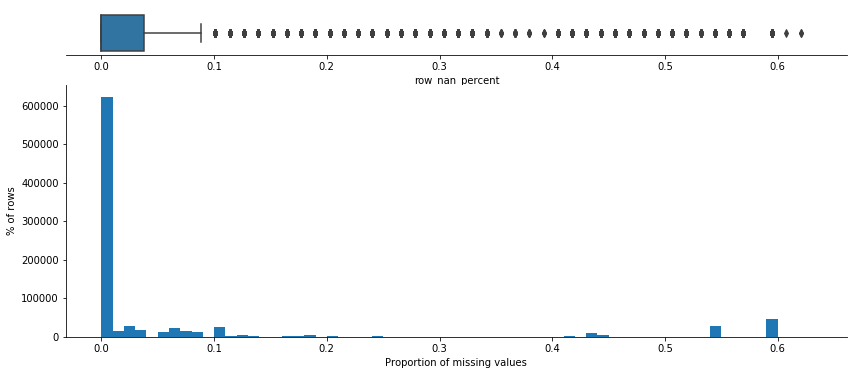

In [24]:
# How much data is missing in each row of the dataset?

dw.genPopulationData['row_nan_percent'] = dw.genPopulationData.isnull().mean(axis=1) 
dw.plotHistogram(x=dw.genPopulationData['row_nan_percent'], x_label='Proportion of missing values', y_label='% of rows', bin_incr=0.01)

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshhold = 0.10

dfLowMissing = dw.genPopulationData.loc[dw.genPopulationData['row_nan_percent'] < threshhold, :]
dfHighMissing = dw.genPopulationData.loc[dw.genPopulationData['row_nan_percent'] > threshhold, :]
print("Shapes:")
print(f"\thigh: {dfHighMissing.shape} low: {dfLowMissing.shape}")
print("Proportions of count:")
print(f"\tlow to total: {dfLowMissing.shape[0] / dw.genPopulationData.shape[0]}")
print(f"\thigh to total: {dfHighMissing.shape[0] / dw.genPopulationData.shape[0]}")

Shapes:
	high: (144112, 80) low: (747109, 80)
Proportions of count:
	low to total: 0.8382982447675716
	high to total: 0.16170175523242833


#### Discussion 1.1.3: Assess Missing Data in Each Row

I observe from the plots above that the distributions are discrete and look distinctly different. The data with lots of missing values are intrinsically different from the data with few or no missing values.

In summary, 10% is the threshhold that we used to split the data into two separate subsets. And then we compared the two distributions by taking five sample columns that do not have any NaN values. We found that 83.8% of the rows are below the 10% threshold of missing values. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# Keep only the rows with NaNs below 10% and then drop the row_nan_percent row
df = dfLowMissing
df = df[df.columns[:-1]]
df.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
3                   4.0        2.0            2.0                4.0   
4                   3.0        1.0            5.0                4.0   
5                   1.0        2.0            2.0                3.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
3            2.0               5.0             2.0                    1.0   
4            3.0               4.0             1.0                    3.0   
5            1.0               5.0             2.0                    2.0   

   FINANZ_HAUSBAUER  FINANZTYP    ...     PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
1               5.0        1.0    ...            2.0         3.0         2.0   
2               5.0        1.0    ...            3.0         3.0         1.0   
3               2.0        6.0    ...            2.0         2.0         2.0   
4               2.0        5.0    ...            2.0         4.0         2.0   
5               5.0        2.0    ...            2.0         3.0         1.0   

   PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  
1         1.0          1.0       5.0       4.0     3.0          5.0       4.0  
2         0.0          1.0       4.0       4.0     3.0          5.0       2.0  
3         0.0          1.0       3.0       4.0     2.0          3.0       3.0  
4         1.0          2.0       3.0       3.0     4.0          6.0       5.0  
5         1.0          1.0       5.0       5.0     2.0          3.0       3.0  

[5 rows x 79 columns]

In [27]:
# Drop the missing_or_unknown column from the processed feature info dataset
dw.featInfo = dw.featInfo[dw.featInfo.columns[:-1]]
dw.featInfo.head()

attribute information_level         type
0              AGER_TYP            person  categorical
1  ALTERSKATEGORIE_GROB            person      ordinal
2             ANREDE_KZ            person  categorical
3         CJT_GESAMTTYP            person  categorical
4     FINANZ_MINIMALIST            person      ordinal

In [28]:
# filter feat_info to the remaining columns
dw.featInfo = dw.featInfo[dw.featInfo.attribute.isin(df.columns)]
print(f"shape: {dw.featInfo.shape}")
dw.featInfo.head()

shape: (79, 3)


attribute information_level         type
1  ALTERSKATEGORIE_GROB            person      ordinal
2             ANREDE_KZ            person  categorical
3         CJT_GESAMTTYP            person  categorical
4     FINANZ_MINIMALIST            person      ordinal
5         FINANZ_SPARER            person      ordinal

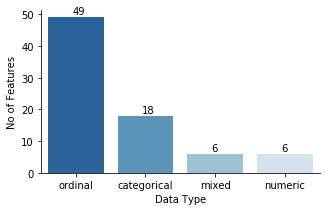

In [29]:
# How many features are there of each data type?

#Let's create a countplot
f, a = plt.subplots(figsize=(5,3))
sns.countplot(data=dw.featInfo,
              x='type',
              color='b',
              palette='Blues_r',
              ax=a)
a.set_xlabel('Data Type')
a.set_ylabel('No of Features')

for q in a.patches:
    a.annotate('{:.0f}'.format(q.get_height()), (q.get_x()+0.35, q.get_height()+1))
sns.despine(ax=a);

***Observations:***
  - 62% of the features belong to ordinal data type
  - 30.38% represent the categorical and mixed data types combined

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Get the categorical features
dw.featInfo[dw.featInfo.type == 'categorical']

attribute information_level         type
2          ANREDE_KZ            person  categorical
3      CJT_GESAMTTYP            person  categorical
10         FINANZTYP            person  categorical
12   GFK_URLAUBERTYP            person  categorical
13  GREEN_AVANTGARDE            person  categorical
17   LP_FAMILIE_FEIN            person  categorical
18   LP_FAMILIE_GROB            person  categorical
19    LP_STATUS_FEIN            person  categorical
20    LP_STATUS_GROB            person  categorical
21  NATIONALITAET_KZ            person  categorical
38       SHOPPER_TYP            person  categorical
39           SOHO_KZ            person  categorical
41          VERS_TYP            person  categorical
42          ZABEOTYP            person  categorical
52       GEBAEUDETYP          building  categorical
55       OST_WEST_KZ          building  categorical
57   CAMEO_DEUG_2015     microcell_rr4  categorical
58    CAMEO_DEU_2015     microcell_rr4  categorical

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Find which ones are binaries. To start with, we need to find the number of categorical data 
# in each information level and see if they are distinctly ==2 or greater than 2;
# we have a counting problem. Then we'll investigate the data if it needs re-encoded or not.

df_cols_category = dw.featInfo[dw.featInfo.type == 'categorical'].attribute
df_cols_category

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [32]:
# The number of binaries 
print(f"Number of binaries: {sum(df[df_cols_category].nunique() == 2)}")
# Number of multilevel
print(f"Number of multilevels: {sum(df[df_cols_category].nunique() != 2)}")

Number of binaries: 5
Number of multilevels: 13


In [33]:
# Let's have a look at the object data types
df.dtypes[df.dtypes == 'object']

OST_WEST_KZ        object
CAMEO_DEUG_2015    object
CAMEO_DEU_2015     object
CAMEO_INTL_2015    object
dtype: object

In [34]:
# In our caterogical data in df_cols_category, we got 3 object data types; let's have a look
df[df_cols_category[-3:]].sample(10)

OST_WEST_KZ CAMEO_DEUG_2015 CAMEO_DEU_2015
132705           W               7             7A
413452           W               3             3D
326370           W               9             9B
576075           O               9             9B
412780           W               7             7A
624827           W               3             3A
713259           W               6             6B
282173           O               3             3D
74032            W               9             9D
661519           W               2             2D


-  CAMEO_DEUG_2015 German CAMEO: Wealth / Life Stage Typology, rough scale (1: upper class, 9: urban working class)
is a multilevel categorical feature and will be transformed to a dummy variable (or dropped) so it can stay like this for now.
CAMEO_DEUG_2015 should be a float64 data type but is encoded as object.
-  CAMEO_DEU_2015 is a more granular version of CAMEO_DEUG_2015 and is probably highly correlated. Further investigation should be done.
- OST_WEST_KZ: Building location via former East / West Germany (GDR / FRG) (O: East (GDR), W: West (FRG))
is a binary categorical variable; we will re-encode the string representation in numerical type so that it can be used with the algorithms.

In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Convert the binary OST_WEST_KZ to numeric categories
df = df.copy()
if df['OST_WEST_KZ'].dtype != 'int64': # safety check in case we need a rerun, we can skip this step post-conversion
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W': 1, 'O': 0})

In [36]:
# test
df[df_cols_category[-3:]].sample(10)

OST_WEST_KZ CAMEO_DEUG_2015 CAMEO_DEU_2015
846448            1               2             2D
243025            1               1             1B
422947            1               6             6B
535009            1               2             2A
172651            1               9             9A
727599            1               7             7B
173734            1               7             7B
797585            1               4             4E
178645            1               6             6E
868398            1               6             6B

In [37]:
# Let's move on to multilevel categorical features re-encoding
uniq = df[df_cols_category].nunique()
encode_multicat = uniq[uniq > 2]
encode_multicat.sort_values()

NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_FAMILIE_GROB      5
LP_STATUS_GROB       5
CJT_GESAMTTYP        6
FINANZTYP            6
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [38]:
# Let's drop the multi-level in this iteration
df = df.drop(columns=encode_multicat.index, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747109 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     744640 non-null float64
ANREDE_KZ                747109 non-null float64
FINANZ_MINIMALIST        747109 non-null float64
FINANZ_SPARER            747109 non-null float64
FINANZ_VORSORGER         747109 non-null float64
FINANZ_ANLEGER           747109 non-null float64
FINANZ_UNAUFFAELLIGER    747109 non-null float64
FINANZ_HAUSBAUER         747109 non-null float64
GREEN_AVANTGARDE         747109 non-null float64
HEALTH_TYP               722753 non-null float64
LP_LEBENSPHASE_FEIN      714735 non-null float64
LP_LEBENSPHASE_GROB      717274 non-null float64
PRAEGENDE_JUGENDJAHRE    730988 non-null float64
RETOURTYP_BK_S           747109 non-null float64
SEMIO_SOZ                747109 non-null float64
SEMIO_FAM                747109 non-null float64
SEMIO_REL                747109 non-null float64
SEMIO_MAT                747109 non-null float64
SEMIO_V

#### Discussion 1.2.1: Re-Encode Categorical Features

Overall there are 18 categorical variables, 13 of which are multi-level and 5 are binary.

The plan is that the 13 multi-level categorical variables will be one-hot encoded in order to be used in the algorithms. Two(2) binary variables, OST_WEST_KZ and CAMEO_DEUG_2015 will be both re-encoded. The rest of the binary variables will be kept as-is.

Datasets like CAMEO_DEUG_2015 is sort of redundant info for CAMEO_DEU_2015 or FINANZ_ for FINANZTYP, LP_STATUS_FEIN and LP_STATUS_GROB for LP_FAMILIE_FEIN and LP_FAMILIE_GROB, so we will choose to drop them at this iteration of the analysis to not increase the number of variables too much at this phase.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Print the features with mixed data type 
dw.featInfo[dw.featInfo.type == 'mixed']

attribute information_level   type
15    LP_LEBENSPHASE_FEIN            person  mixed
16    LP_LEBENSPHASE_GROB            person  mixed
22  PRAEGENDE_JUGENDJAHRE            person  mixed
56               WOHNLAGE          building  mixed
59        CAMEO_INTL_2015     microcell_rr4  mixed
79            PLZ8_BAUMAX    macrocell_plz8  mixed

In [130]:
# Read MD file

def cat_md_file():
    file1 = open('Data_Dictionary.md', 'r') 
    lines = file1.readlines() 
  
    for line in lines: 
        print(line)
    
    file1.close()        

In [132]:
cat_md_file()

# Data Dictionary for Identify Customer Segments Data



## Introduction



The data for this project consist of two files:



- Udacity_AZDIAS_Subset.csv: demographics data for the general population of

      Germany; 891211 persons (rows) x 85 features (columns)

- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order

      company; 191652 persons (rows) x 85 features (columns)



The columns in the general demographics file and customers data file are the

same. This file documents the features that appear in the data files, sorted in

order of appearance. Sections of this file is based on the level of measurement

of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of

feature attributes, including information level, data type, and codes for

missing or unknown values.



### Table of Contents



 1. Person-level features

 2. Household-level features

 3. Building-level features

 4. RR4 micro-cell features

 5. RR3 micro-cell featur

In [41]:
df.PRAEGENDE_JUGENDJAHRE.sample(10)

879138     9.0
80508     10.0
552093    10.0
421026     8.0
365851     8.0
59974     14.0
815053     4.0
41316      6.0
804963    14.0
823909     1.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [42]:
df.PRAEGENDE_JUGENDJAHRE.nunique()

15

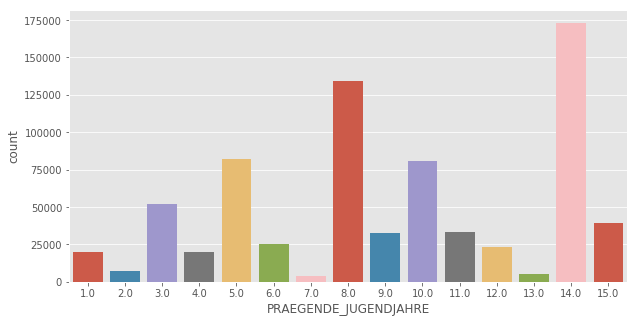

In [43]:
plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(10,5))
sns.countplot(data=df,
              x='PRAEGENDE_JUGENDJAHRE',
              palette=sns.color_palette(),
              ax=ax);

In [44]:
# Get more info on NULLs
print(f"mean (nulls):\t{df.PRAEGENDE_JUGENDJAHRE.isnull().mean() * 100:.2f}%")
print(f"total nulls:\t{df.PRAEGENDE_JUGENDJAHRE.isnull().sum()}")

mean (nulls):	2.16%
total nulls:	16121


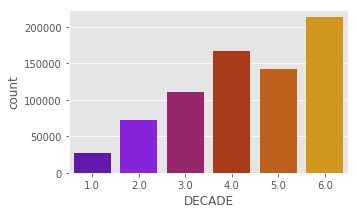

In [45]:
# Engineer two new variables, DECADE and MOVEMENT

movement_map = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                }
decade_map = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
               8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
               14: 6, 15: 6
              }

df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)

# plot it
f, ax = plt.subplots(figsize=(5,3))
sns.countplot(data=df,
              x='DECADE',
              palette="gnuplot",
              ax=ax);

In [46]:
# Smoke check

df.DECADE.value_counts()


6.0    212488
4.0    166658
5.0    142337
3.0    110730
2.0     71852
1.0     26923
Name: DECADE, dtype: int64

In [47]:
df.DECADE.isnull().sum()

16121

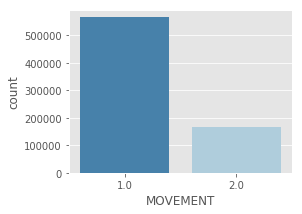

In [48]:
# MOVEMENT count plot

fig, ax1 = plt.subplots(figsize=(4,3))
sns.countplot(data=df,
              x='MOVEMENT',
              palette=sns.color_palette("RdBu_r", n_colors=5),
              ax=ax1);

In [49]:
# print count and sum
print(f"count:\n{df.MOVEMENT.value_counts()}\n")
print(f"sum: {df.MOVEMENT.isnull().sum()}")

count:
1.0    564070
2.0    166918
Name: MOVEMENT, dtype: int64

sum: 16121


In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Display some data from it
df.CAMEO_INTL_2015.head(10)

1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
10    51
Name: CAMEO_INTL_2015, dtype: object

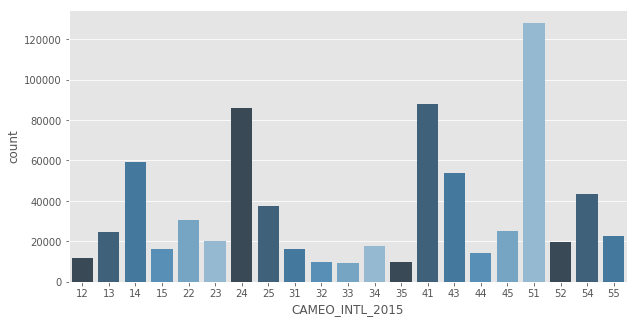

In [51]:
# let's plot it out
fig, ax1 = plt.subplots(figsize=(10,5))
levels_sort = [str(int(l)) for l in np.sort(df.CAMEO_INTL_2015.astype(float).unique())[:-1]]
color_map = dict(zip())
sns.countplot(data=df,
              x='CAMEO_INTL_2015',
              palette = sns.color_palette("Blues_d"),
              order = levels_sort,
              ax=ax1);

In [52]:
# print count and sum
print(f"count:\n{df.CAMEO_INTL_2015.value_counts()}\n")
print(f"sum (nulls): {df.CAMEO_INTL_2015.isnull().sum()}")
print(f"mean (nulls): {df.CAMEO_INTL_2015.isnull().mean() * 100:.2f}%")

count:
51    128033
41     87902
24     85759
14     59027
43     54044
54     43637
25     37564
22     30589
45     25124
13     24528
55     22681
23     20328
52     19627
34     17537
15     16296
31     16285
44     14117
12     11980
35      9882
32      9777
33      9161
Name: CAMEO_INTL_2015, dtype: int64

sum (nulls): 3231
mean (nulls): 0.43%


In [53]:
def split_codes(x, digit):
    ''' Splits up  two-digit codes by their
    'tens'-place and 'ones'-place digits
    into two new ordinal variables.
    Leaves NaNs unchanged'''

    if not pd.isna(x):
        if digit == 'first':
            return int(str(x)[0])
        elif digit == 'second':
            return int(str(x)[1])
    return x


In [54]:
# Engineer two new variables, WEALTH and LIFE_STAGE
df['WEALTH'] = df['CAMEO_INTL_2015'].apply(split_codes, digit='first')
df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(split_codes, digit='second')

In [55]:
df.head(10)

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                    1.0        2.0                1.0            5.0   
2                    3.0        2.0                1.0            4.0   
3                    4.0        2.0                4.0            2.0   
4                    3.0        1.0                4.0            3.0   
5                    1.0        2.0                3.0            1.0   
6                    2.0        2.0                1.0            5.0   
7                    1.0        1.0                3.0            3.0   
8                    3.0        1.0                4.0            4.0   
9                    3.0        2.0                2.0            4.0   
10                   3.0        2.0                2.0            2.0   

    FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                2.0             5.0                    4.0               5.0   
2                1.0             2.0                    3.0               5.0   
3                5.0             2.0                    1.0               2.0   
4                4.0             1.0                    3.0               2.0   
5                5.0             2.0                    2.0               5.0   
6                1.0             5.0                    4.0               3.0   
7                4.0             1.0                    3.0               2.0   
8                2.0             4.0                    2.0               2.0   
9                2.0             3.0                    5.0               4.0   
10               5.0             3.0                    1.0               5.0   

    GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
1                0.0         3.0     ...              1.0       5.0       4.0   
2                1.0         3.0     ...              1.0       4.0       4.0   
3                0.0         2.0     ...              1.0       3.0       4.0   
4                0.0         3.0     ...              2.0       3.0       3.0   
5                0.0         3.0     ...              1.0       5.0       5.0   
6                0.0         2.0     ...              1.0       5.0       5.0   
7                0.0         1.0     ...              1.0       4.0       4.0   
8                1.0         3.0     ...              1.0       3.0       3.0   
9                1.0         2.0     ...              1.0       3.0       3.0   
10               0.0         2.0     ...              2.0       3.0       3.0   

    ARBEIT  ORTSGR_KLS9  RELAT_AB  DECADE  MOVEMENT  WEALTH  LIFE_STAGE  
1      3.0          5.0       4.0     6.0       1.0     5.0         1.0  
2      3.0          5.0       2.0     6.0       2.0     2.0         4.0  
3      2.0          3.0       3.0     4.0       1.0     1.0         2.0  
4      4.0          6.0       5.0     4.0       1.0     4.0         3.0  
5      2.0          3.0       3.0     2.0       1.0     5.0         4.0  
6      4.0          6.0       3.0     5.0       1.0     2.0         2.0  
7      2.0          5.0       2.0     4.0       1.0     1.0         4.0  
8      2.0          4.0       3.0     5.0       2.0     1.0         3.0  
9      2.0          3.0       1.0     6.0       2.0     1.0         5.0  
10     4.0          6.0       5.0     2.0       1.0     5.0         1.0  

[10 rows x 70 columns]

WEALTH count:
5.0    213978
4.0    181187
2.0    174240
1.0    111831
3.0     62642
Name: WEALTH, dtype: int64

WEALTH sum (nulls): 3231
WEALTH mean (nulls): 0.43%


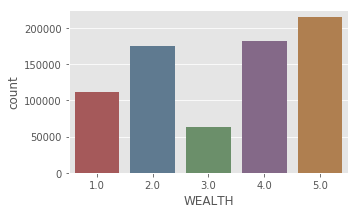

In [56]:
# plot it
fig, ax1 = plt.subplots(figsize=(5,3))
sns.countplot(data=df,
              x='WEALTH',
              palette=sns.color_palette("Set1", n_colors=8, desat=.5),
              ax=ax1);

# print count and sum
print(f"WEALTH count:\n{df.WEALTH.value_counts()}\n")
print(f"WEALTH sum (nulls): {df.WEALTH.isnull().sum()}")
print(f"WEALTH mean (nulls): {df.WEALTH.isnull().mean() * 100:.2f}%")

LIFE_STAGE count:
1.0    232220
4.0    220077
5.0    111547
3.0    108061
2.0     71973
Name: LIFE_STAGE, dtype: int64

LIFE_STAGE sum (nulls): 3231
LIFE_STAGE mean (nulls): 0.43%


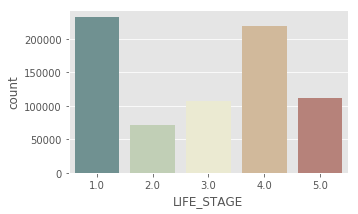

In [57]:
# Moving on to LIFE_STAGE, let's plot it
fig, ax1 = plt.subplots(figsize=(5,3))
sns.countplot(data=df,
              x='LIFE_STAGE',
              palette = sns.color_palette("Spectral_r", n_colors=5, desat=.5),
              ax=ax1);

# print count and sum
print(f"LIFE_STAGE count:\n{df.LIFE_STAGE.value_counts()}\n")
print(f"LIFE_STAGE sum (nulls): {df.LIFE_STAGE.isnull().sum()}")
print(f"LIFE_STAGE mean (nulls): {df.LIFE_STAGE.isnull().mean() * 100:.2f}%")

In [58]:
# Going back a little bit on the mixed stats
mixed_feature_cols = dw.featInfo[dw.featInfo.type == 'mixed'].attribute
mixed_feature_cols

# Drop mixed dtype features
df = df.drop(mixed_feature_cols, axis=1)
df.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  \
1               0.0         3.0     ...             1.0       5.0       4.0   
2               1.0         3.0     ...             0.0       4.0       4.0   
3               0.0         2.0     ...             0.0       3.0       4.0   
4               0.0         3.0     ...             1.0       3.0       3.0   
5               0.0         3.0     ...             1.0       5.0       5.0   

   ARBEIT  ORTSGR_KLS9  RELAT_AB  DECADE  MOVEMENT  WEALTH  LIFE_STAGE  
1     3.0          5.0       4.0     6.0       1.0     5.0         1.0  
2     3.0          5.0       2.0     6.0       2.0     2.0         4.0  
3     2.0          3.0       3.0     4.0       1.0     1.0         2.0  
4     4.0          6.0       5.0     4.0       1.0     4.0         3.0  
5     2.0          3.0       3.0     2.0       1.0     5.0         4.0  

[5 rows x 64 columns]

#### Discussion 1.2.2: Engineer Mixed-Type Features

The dataset contains 6 mixed variables, 13 of which are multilevel and 5 are binary.

Following the data dictionary's hints, I have decided to split the mixed variables to two as required using these column names:

**PRAEGENDE_JUGENDJAHRE Mixed Dataset**

- ***DECADE***: Person’s decade of youth, and

- ***MOVEMENT***: Person’s movement alignment (1: Mainstream, 2: Avantgarde )

**Mixed Feature CAMEO_INTL_2015**

- ***WEALTH***: Household's wealth (1: Wealthy Households, 5: Poorer Households):

- ***LIFE_STAGE***: Person's Life Stage (Pre-Family Couples & Singles, 5: Elders In Retirement):

The rest of the mixed features are:

|Feature	| # of Levels |
|-----------|------------- |
LP_LEBENSPHASE_FEIN|	40
LP_LEBENSPHASE_GROB	|12
WOHNLAGE	|8
PLZ8_BAUMAX	|5

which we chose to drop in this iteration of the analysis as part of feature selection process.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [59]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

df.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   
5                   1.0        2.0                3.0            1.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   
5               5.0             2.0                    2.0               5.0   

   GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  \
1               0.0         3.0     ...             1.0       5.0       4.0   
2               1.0         3.0     ...             0.0       4.0       4.0   
3               0.0         2.0     ...             0.0       3.0       4.0   
4               0.0         3.0     ...             1.0       3.0       3.0   
5               0.0         3.0     ...             1.0       5.0       5.0   

   ARBEIT  ORTSGR_KLS9  RELAT_AB  DECADE  MOVEMENT  WEALTH  LIFE_STAGE  
1     3.0          5.0       4.0     6.0       1.0     5.0         1.0  
2     3.0          5.0       2.0     6.0       2.0     2.0         4.0  
3     2.0          3.0       3.0     4.0       1.0     1.0         2.0  
4     4.0          6.0       5.0     4.0       1.0     4.0         3.0  
5     2.0          3.0       3.0     2.0       1.0     5.0         4.0  

[5 rows x 64 columns]

In [60]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

df.shape

(747109, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [61]:
# Since I've already created a DataWrangler class, I will reuse some of the logic of that class
import sys

class DataCleaner:
    
    def __init__(self, data, featInfo, threshhold=0.10, debug=False):
        self.df = data.copy()
        self.featInfo = featInfo
        self.nullsPercentBefore = None
        self.nullsPercentAfter = None
        self.debug = debug
        self.threshhold = threshhold
        
    # Scrub all missing or unknown data to NaN    
    def convertMissingToNaN(self, initial=True, debug=False):
        # Convert to NaNs using our new self.missingDataEncode map
        if not initial: return self.deltas
        
        print("Converting missing data to NaN: Please wait. This can take a while.", end="")    
        result = dict()
        
        i = 0
        for col in self.missingDataEncode.keys():
            i = i + 1
            if i % 10 ==0: print(".", end="")
            nans_before = self.df[col].isnull().sum()
            if debug:
                print(col, 'NaNs before: ', nans_before)
            self.df.loc[self.df[col].isin(self.missingDataEncode[col]), col] = np.nan
            
            nans_after = self.df[col].isnull().sum()
            if debug:
                print(col, 'NaNs after: ', nans_after, '\n')
                
            if nans_after != nans_before:
                result[col] = [nans_before, nans_after]

                self.deltas = pd.DataFrame.from_dict(result)
        print(". Done.")        
        return self.deltas
    
    def categorizeMissingData(self):
        if self.nullsPercentAfter is None: 
            print("Error: run and load the data first.")
            return None
        
        # Merge feature info with nan percentage data
        nan_perc_df = pd.DataFrame(self.nullsPercentAfter, columns=['nan_percent'])
        self.featNan = (self.featInfo.merge(nan_perc_df, left_on='attribute', \
                                            right_index=True).drop(columns='missing_or_unknown', axis=1))

        # Split the data into three categories:
        # High percentage of nans (>20%)
        # Moderate percentage of nans (5-20%)
        # Low percentage of nans (0-5%)
        # No NaNs
        self.featNan['nan_category'] = pd.cut(self.featNan.nan_percent, bins=[-np.inf, 0, 10, 20, np.inf], \
                                              labels=['zero', 'low', 'moderate', 'high'])
        return self.featNan
    
    def percentNullsBefore(self, numRows=20, debug=False):    
        # find out the different kind of encodings before processing
        if self.nullsPercentBefore is None:
            self.nullsPercentBefore = (self.df.isnull().mean() * 100).sort_values(ascending=False)
        if debug:
            print(self.nullsPercentBefore[:numRows])

    def percentNullsAfter(self, numRows=20, debug=False):    
    
        if self.nullsPercentAfter is None:
            self.nullsPercentAfter = (self.df.isnull().mean() * 100).sort_values(ascending=False)
        if debug:
            print(self.nullsPercentAfter[:numRows])
        
    def printPreprocessedRowsWithNoNaNs(self):
        #How many rows don't have nans before preprocessing?
        print(f'Number of rows that have no NaNs: {self.nullsPercentBefore[self.nullsPercentBefore == 0].shape[0]}')
        
        nanPercent = round(self.df.isnull().sum().sum() / np.product(self.df.shape) * 100, 2)
        print(f"Total percentage of Nans: {nanPercent}%")
    
    def printProcessedRowsWithNoNaNs(self):
        #How many rows don't have nans before preprocessing?
        print(f'Number of rows that have no NaNs: {self.nullsPercentAfter[self.nullsPercentAfter == 0].shape[0]}')
        
        nanPercent = round(self.df.isnull().sum().sum() / np.product(self.df.shape) * 100, 2)
        print(f"Total percentage of Nans: {nanPercent}%")
        
    '''Take an array as input and draw a histogram with a boxplot above it'''    
    def plotHistogram(self, x_label='Proportion of missing values', y_label='% of features', bin_incr=0.05, x=None):
        if x is None:
            x=self.nullsPercentBefore/100           
                
        fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={ "height_ratios": (.15, .85)}, figsize=(14, 6))
        sns.boxplot(x, ax=ax_box)
        bins = np.arange(0, x.max() + bin_incr, bin_incr)
        x.hist(grid=False, bins=bins)
        
        ax_box.set(yticks=[])
        ax_hist.set_ylabel(y_label)
        ax_hist.set_xlabel(x_label)
        sns.despine(ax=ax_hist)
        sns.despine(ax=ax_box, left=True)

    '''Takes the column with the missing value encodings and converts to list, specially processing the casses where X or  
       XX is in the encodings'''    
    def xOrXXToListLambda(self, s):
        if 'XX' in s:
            if len(s) == 4:
                return [s[1:-1]]
            else:
                return [-1, 'XX']
        elif 'X' in s:
            return [-1, 'X']
        else:
            return eval(s) if type(s) == str or type(s) == bytes else s
        
    def xOrXXToList(self):
        self.featInfo.missing_or_unknown = self.featInfo.missing_or_unknown.apply(self.xOrXXToListLambda)
        return self.featInfo   

    ''' Create a dictionary to map column names to missing data encodings'''
    def encodeMissingData(self):
        self.missingDataEncode = dict(zip(self.featInfo.attribute, self.featInfo.missing_or_unknown))
        return self.missingDataEncode
    
    def doCountPlotOfMissingValues(self):
        
        if self.featNan is None:
            print("Error: get the feature and NaN mapping first before running this.")
            return None
        
        fig, ax1 = plt.subplots(figsize=(14,8))
        order = ['person', 'household', 'building', 'postcode', 'community',
           'microcell_rr3', 'microcell_rr4', 'region_rr1', 'macrocell_plz8']
        hue_order = ['zero', 'low', 'moderate', 'high']
        sns.countplot(data=self.featNan,
                  x='information_level',
                  hue='nan_category',
                  order=order,
                  hue_order=hue_order,
                  ax=ax1)
        plt.legend(loc='upper right')
        sns.despine(ax=ax1)
        
    def dropColumnOutliers(self):
        if self.df is None:
            print('Error: load data first before running this method')
            return None
        featuresToRemove = self.featNan[self.featNan.nan_category == 'high'].attribute     
        
        if featuresToRemove is not None and len(featuresToRemove) > 0:
            self.df = DataCleaner.dropSelectedColumns(self.df, list(featuresToRemove))
        else: print("WARNING: No column outliers satisfy the condition. No column drops occurred.")
    
    def dropRowOutliers(self, debug=False):
        self.df['row_nan_percent'] = self.df.isnull().mean(axis=1) 
        threshhold = self.threshhold

        dfLowMissing = self.df.loc[self.df['row_nan_percent'] < threshhold, :]
        dfHighMissing = self.df.loc[self.df['row_nan_percent'] > threshhold, :]
        
        if debug:
            print("Shapes:")
            print(f"\thigh: {dfHighMissing.shape} low: {dfLowMissing.shape}")            
            print("Proportions of count:")
            print(f"\tlow to total: {dfLowMissing.shape[0] / self.df.shape[0]}")
            print(f"\thigh to total: {dfHighMissing.shape[0] / self.df.shape[0]}")            
            
        # keep only the rows with lowest NaNs
        self.df = dfLowMissing
        self.df = self.df[self.df.columns[:-1]]
        # Drop the missing_or_unknown column from the processed feat_info Df
        self.featInfo = self.featInfo[self.featInfo.columns[:-1]]
        # filter feat_info to the remaining columns
        self.featInfo = self.featInfo[self.featInfo.attribute.isin(self.df.columns)]
        
        return self.df, dfHighMissing
    
    @staticmethod
    def assertAllNumeric(df):
        from pandas.api.types import is_numeric_dtype

        #should be equal to the no of cols if all True
        assert(sum([is_numeric_dtype(df[col]) for col in df.columns]) == df.shape[1])
        print('Tests OK')

    @staticmethod
    def dropSelectedColumns(dfInstance, cols_to_remove, axis=1 ):
        '''Drop cols provided from the dataset'''
        d = dfInstance.copy()
        print(f"Shape before dropping Column outliers at this phase: {d.shape}")
        print(f"Dropping columns: {cols_to_remove}")
        for col in cols_to_remove:
            try:
                d = d.drop(columns=col, axis=axis)
            except:
                print(sys.exc_info())
        print(f"New shape after dropping Column outliers at this phase: {d.shape}\n")                
        return d

    def encodeCategoricalFeatures(self, force=False):
        df2 = self.df.copy()
        # safety check in case we need a rerun, we can skip this step post-conversion
        if df2.get('OST_WEST_KZ') is not None and df2['OST_WEST_KZ'].dtype != 'int64' or force: 
            df2['OST_WEST_KZ'] = df2['OST_WEST_KZ'].replace({'W': 1, 'O': 0})
    
        # Let's move on to multilevel categorical features re-encoding
        df_cols_category = self.featInfo[self.featInfo.type == 'categorical'].attribute
        labels = [val for val in list(df_cols_category) if val in list(df2.columns) ]
        # Add reindex to not have KeyError

        uniq = df2[labels].nunique()
        self.encode_multicat = uniq[uniq > 2]
        # Let's drop the multi-level in this iteration
        self.df = df2.drop(columns=self.encode_multicat.index, axis=0)
        return self.df

    def reEngineerMixedFeatures(self):
        
        # Engineer two new variables from 'PRAEGENDE_JUGENDJAHRE'
        decadeMap = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
                       8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
                       14: 6, 15: 6
                       }
        movementMap = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                         2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                         }
        if self.df.get('PRAEGENDE_JUGENDJAHRE') is not None:
            print('Re-engineering PRAEGENDE_JUGENDJAHRE feature to DECADE and MOVEMENT:')
            self.df['DECADE'] = self.df['PRAEGENDE_JUGENDJAHRE'].map(decadeMap)
            self.df['MOVEMENT'] = self.df['PRAEGENDE_JUGENDJAHRE'].map(movementMap)
        else:
            print('WARNING: PRAEGENDE_JUGENDJAHRE feature was dropped prior to re-engineering routinue..')
        # Engineer two new variables, WEALTH and LIFE_STAGE
        if self.df.get('CAMEO_INTL_2015') is not None:
            print('Re-engineering CAMEO_INTL_2015 feature to WEALTH and LIFE_STAGE:')
            self.df['WEALTH'] = self.df['CAMEO_INTL_2015'].apply(DataCleaner.splitCodes, digit='first')
            self.df['LIFE_STAGE'] = self.df['CAMEO_INTL_2015'].apply(DataCleaner.splitCodes, digit='second')
        else:
            print('WARNING: CAMEO_INTL_2015 feature was dropped prior to re-engineering routinue..')

         # Drop mixed dtype features
        self.mixedFeatureCols = self.featInfo[self.featInfo.type == 'mixed'].attribute    
        if self.mixedFeatureCols is not None and len(self.mixedFeatureCols) > 0:
            self.df = DataCleaner.dropSelectedColumns(self.df, self.mixedFeatureCols)
        else: print ("WARNING: No mixed datatype feature were dropped..")    
        return self.df
    
    @staticmethod
    def splitCodes(x, digit):
        ''' Splits up  two-digit codes by their
        'tens'-place and 'ones'-place digits
        into two new ordinal variables.
        Leaves NaNs unchanged'''

        if not pd.isna(x):
            if digit == 'first':
                return int(str(x)[0])
            elif digit == 'second':
                return int(str(x)[1])
        return x
    
    @staticmethod
    def intersect(lst1, lst2): 
        return [value for value in lst1 if value in lst2] 

    @staticmethod
    def unionNoDups(first_list, second_list):
        return first_list + list(set(second_list) - set(first_list))
    
    ''' Main data cleaning method'''    
    def clean(self, debug=False):
        
        #Initialize
        self.percentNullsBefore(debug=debug)
        self.printPreprocessedRowsWithNoNaNs()
        self.plotHistogram()
        self.xOrXXToList()
        self.encodeMissingData()        
        
        # convert missing value codes into NaNs, ...       
        self.convertMissingToNaN(initial=True, debug=debug)
        self.percentNullsAfter(debug=debug)
        self.printProcessedRowsWithNoNaNs()
        
        # Histogram post-processing
        self.plotHistogram(x=self.nullsPercentAfter/100)
        
        self.categorizeMissingData() 
        # Do a SwarmPlot so we can visualize the data further
        self.doCountPlotOfMissingValues()
        # remove selected columns , ...
        self.dropColumnOutliers()
        
        # remove selected rows and return both dfs
        self.dfLowNaN, self.dfHighNaN = self.dropRowOutliers(debug=debug)
        
        # select, re-encode, and engineer column values.
        self.encodeCategoricalFeatures()
                
        # re-engineer column values
        self.df = self.reEngineerMixedFeatures()
        
        # Return the cleaned dataframe and the high NaN Df.
        return self.df, self.dfHighNaN
    

In [62]:
DataCleaner.assertAllNumeric(df)

Tests OK


Load the dataset, OK
Number of rows that have no NaNs: 32
Total percentage of Nans: 6.46%
Converting missing data to NaN: Please wait. This can take a while.......... Done.
Number of rows that have no NaNs: 24
Total percentage of Nans: 11.05%
Shape before dropping Column outliers at this phase: (891221, 85)
Dropping columns: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
New shape after dropping Column outliers at this phase: (891221, 79)

Re-engineering PRAEGENDE_JUGENDJAHRE feature to DECADE and MOVEMENT:
Re-engineering CAMEO_INTL_2015 feature to WEALTH and LIFE_STAGE:
Shape before dropping Column outliers at this phase: (747109, 70)
Dropping columns: 15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object
New shape after dropping Column outliers at this phase: (747109, 64)


Tests Passed!


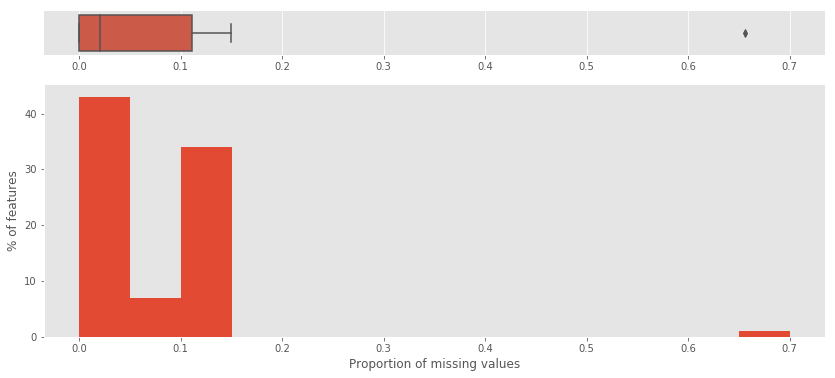

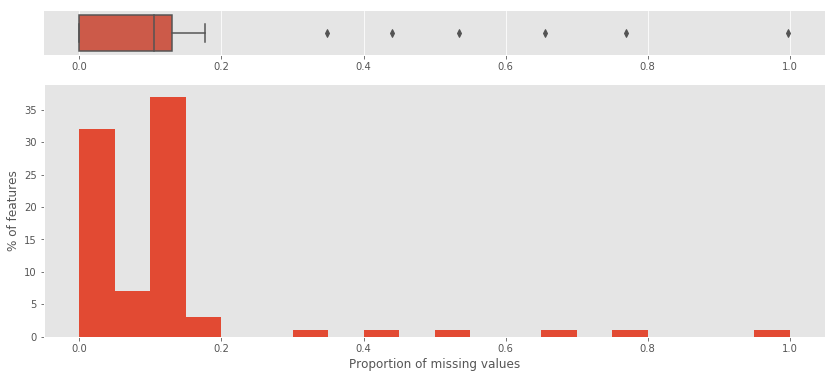

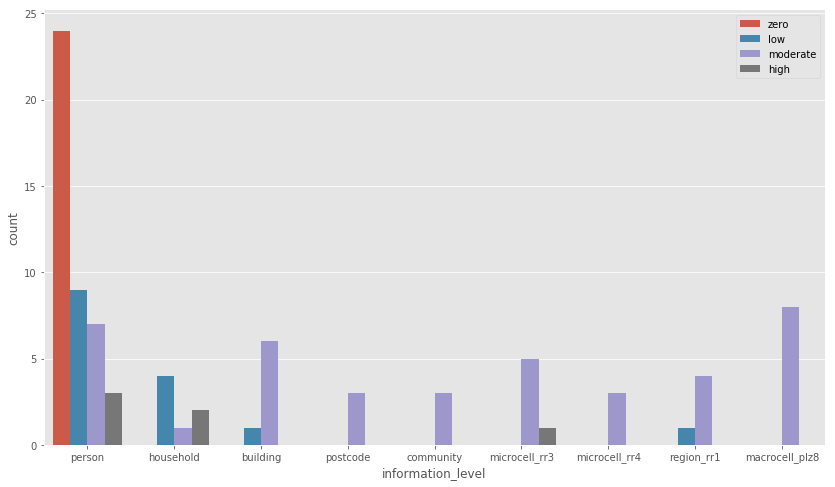

In [63]:
def unitTestCleanData(df):
    '''A simple test function to test that the cleaning function 
    is at least producing an identical Dataframe as the one we created
    '''
    df_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
    print('Load the dataset, OK')
    feat_info_test = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
   
    dc = DataCleaner(df_test, feat_info_test, debug=True)
    d = dc.clean(debug=False)
    try:        
        pd.testing.assert_frame_equal(d[0], df)
        print('\nTests Passed!')
    except:
        e = sys.exc_info()
        print(e)
    finally:    
        return dc, d[0], d[1]
     
dc, df_cleaned, high_nan = unitTestCleanData(df)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [64]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# How many rows have nans? %?
nanRow = (df.isnull().mean(axis=1) * 100).sort_values(ascending=False)

# as a percentage of rows
rowNanP=round(nanRow[nanRow > 0].shape[0]/ df.shape[0]  * 100, 4)
print(f"{nanRow[nanRow > 0].shape[0]} row(s) have NaN values, which is about {rowNanP}%")

# How many cols have NaN?
nanCol = (df.isnull().mean(axis=0) * 100).sort_values(ascending=False)
colNanP=round(nanCol[nanCol > 0].shape[0]/ df.shape[0]  * 100, 4)
print(f"{nanCol[nanCol > 0].shape[0]} column(s) have NaN values, which is about {colNanP}%")

# How many total NaNs as %?
print('Total percentage of NaNs: ',
      round(df.isnull().sum().sum() / np.product(df.shape) * 100, 2),
      '%')

123898 row(s) have NaN values, which is about 16.5837%
33 column(s) have NaN values, which is about 0.0044%
Total percentage of NaNs:  0.67 %


In [65]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler, Imputer

# Apply the imputer with missing values in the full data using mean strategy
imputer = Imputer(missing_values='NaN', axis=0, strategy='mean')
X_i= imputer.fit_transform(df)

In [66]:
X_i

array([[ 1.,  2.,  1., ...,  1.,  5.,  1.],
       [ 3.,  2.,  1., ...,  2.,  2.,  4.],
       [ 4.,  2.,  4., ...,  1.,  1.,  2.],
       ..., 
       [ 2.,  2.,  2., ...,  1.,  2.,  4.],
       [ 1.,  1.,  1., ...,  1.,  5.,  1.],
       [ 4.,  1.,  4., ...,  1.,  4.,  3.]])

In [67]:
df_drop = df.dropna(axis=0)
ss = StandardScaler()
ss.fit(df_drop)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [68]:
# Transform the df with the fitted scaler
X_scaled = ss.transform(X_i)

# Check the distribution of the feature with the highest % of NaNs
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
df_scaled.W_KEIT_KIND_HH.describe()

count    747109.000000
mean         -0.001767
std           0.985268
min          -1.839105
25%          -0.688383
50%          -0.001767
75%           1.037699
max           1.037699
Name: W_KEIT_KIND_HH, dtype: float64

In [69]:
# Stats after?
print(f"Total percentage of Nans after  drop: \
    {round(df_drop.isnull().sum().sum() / np.product(df_drop.shape) * 100, 2)}%")

Total percentage of Nans after  drop:     0.0%


In [70]:
df_scaled.describe()

ALTERSKATEGORIE_GROB      ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count         747109.000000  747109.000000      747109.000000  747109.000000   
mean               0.003698       0.015413           0.001930       0.008389   
std                0.997498       0.999536           1.006980       1.008161   
min               -1.746287      -1.022678          -1.512226      -1.141397   
25%               -0.772089      -1.022678          -0.777350      -1.141397   
50%                0.202108       0.977825          -0.042475       0.219832   
75%                1.176305       0.977825           0.692400       0.900446   
max                1.176305       0.977825           1.427276       1.581061   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count     747109.000000   747109.000000          747109.000000   
mean          -0.000648        0.030617               0.024543   
std            0.995106        1.011898               1.009243   
min           -1.765054       -1.221852              -1.139026   
25%           -1.045045       -1.221852              -1.139026   
50%            0.394972        0.158605              -0.410325   
75%            1.114980        0.848833               1.047076   
max            1.114980        1.539061               1.775776   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE     HEALTH_TYP      ...        \
count     747109.000000     747109.000000  747109.000000      ...         
mean          -0.011613         -0.026449       0.000891      ...         
std            1.015730          0.982942       0.979313      ...         
min           -1.588887         -0.553672      -1.591635      ...         
25%           -0.856544         -0.553672      -0.273495      ...         
50%           -0.124201         -0.553672      -0.273495      ...         
75%            0.608142         -0.553672       1.044646      ...         
max            1.340485          1.806125       1.044646      ...         

          PLZ8_ANTG4       PLZ8_HHZ       PLZ8_GBZ         ARBEIT  \
count  747109.000000  747109.000000  747109.000000  747109.000000   
mean       -0.020237      -0.002344       0.020456      -0.019430   
std         0.993209       1.009009       0.996363       1.003865   
min        -0.981973      -2.721004      -2.111170      -2.223015   
25%        -0.981973      -0.639701      -0.314765      -0.201175   
50%         0.384671      -0.002344      -0.314765      -0.201175   
75%         0.384671       0.400951       0.583438       0.809745   
max         1.751315       1.441603       1.481641       1.820665   

         ORTSGR_KLS9       RELAT_AB         DECADE       MOVEMENT  \
count  747109.000000  747109.000000  747109.000000  747109.000000   
mean       -0.034443      -0.021471       0.005359      -0.014822   
std         0.999515       1.002373       0.995194       0.979819   
min        -1.914219      -1.563993      -2.280170      -0.553672   
25%        -0.607437      -0.823841      -0.902320      -0.553672   
50%        -0.171843      -0.083688      -0.213395      -0.553672   
75%         0.699344       0.656464       1.164455      -0.553672   
max         1.570532       1.396616       1.164455       1.806125   

              WEALTH     LIFE_STAGE  
count  747109.000000  747109.000000  
mean       -0.029240      -0.000760  
std         1.003429       0.992829  
min        -1.595951      -1.251111  
25%        -0.909992      -1.251111  
50%         0.461926       0.082843  
75%         1.147884       0.749820  
max         1.147884       1.416797  

[8 rows x 64 columns]

### Discussion 2.1: Apply Feature Scaling

The total percentage of NaNs in the dataset is 0.67% while the percentage of rows that contain NaNs is 16.58%. Since the number is significant, I decided to drop them to not deal with NaNs at this phase. I also applied the imputer with the mean that which  will zero them out after applying StandardScaler. This technique will reinforce higher data quality overall.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [71]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

# Fit with X_scaled
pca = PCA().fit(X_scaled)

In [72]:
def scree_plot(pca, c, ann_f=6, figsize=(12, 9), pct_change=False):
    '''
    Creates a scree plot associated with the principal components
    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    idx = np.arange(num_components) + 1
    if pct_change:
        evr = -pd.Series(pca.explained_variance_ratio_).pct_change()
        # the first item is NaN
        evr = evr[1:].tolist()
        idx = idx[1:]
    else:
        evr = pca.explained_variance_ratio_

    plt.figure(figsize=figsize)
    ax = plt.   subplot(111)
    cumevr = np.cumsum(evr)
    ax.bar(idx, evr, color=c)
    ax.plot(idx, cumevr, color=c)
    for i in range(num_components):
        try:  # Bandage aid - need to fix
            ax.annotate(r"%s%%" % (
                (str(evr[i] * 100)[:4])),
                (idx[i] + 0.2, evr[i]),
                va="bottom", ha="center", fontsize=ann_f)
        except IndexError:
            pass

    ax.xaxis.set_tick_params(width=0)
    ax.set_xticks(idx, minor=False)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

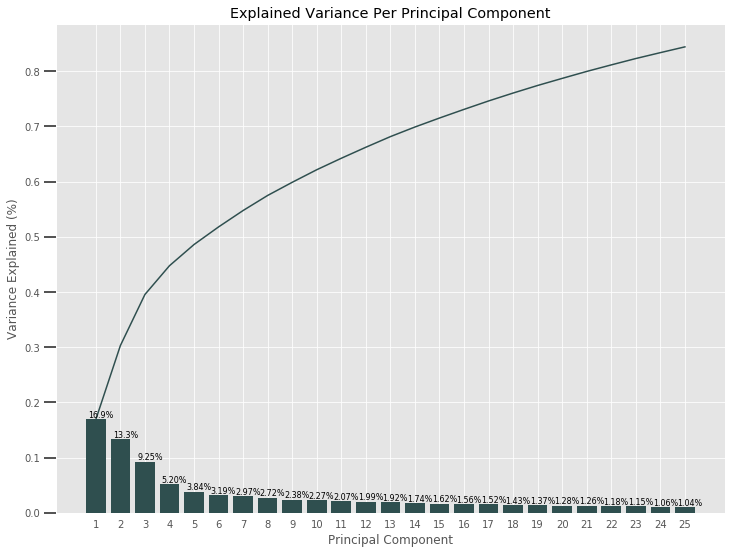

In [73]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_25 = PCA(n_components=25)
X_pca_25 = pca_25.fit(X_scaled)

scree_plot(pca_25, figsize=(12,9), c='darkslategray', ann_f=8)

In [74]:
# Fit on X for 12 components
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Based on the scree plot, 12 seems to be a good number that starts variance stabilization and similarly displaying a stable ratio of cumulative variance.

In [75]:
print(f"The cumulative explained variance of the first 12 components is {np.cumsum(pca.explained_variance_ratio_[:12])[-1]*100:.2f}%.")

The cumulative explained variance of the first 12 components is 66.19%.


In [76]:
df_pca = pd.DataFrame(X_pca)
df_pca.describe()

0             1             2             3             4   \
count  7.471090e+05  7.471090e+05  7.471090e+05  7.471090e+05  7.471090e+05   
mean  -2.980230e-16 -4.350132e-16 -2.277495e-16  4.521322e-17  4.130247e-16   
std    3.305431e+00  2.941747e+00  2.445980e+00  1.834499e+00  1.575509e+00   
min   -8.158595e+00 -8.056214e+00 -5.388300e+00 -5.576731e+00 -6.302874e+00   
25%   -2.797092e+00 -2.248578e+00 -2.213920e+00 -1.315424e+00 -9.996754e-01   
50%   -1.499750e-01  6.887595e-02 -4.477430e-01 -1.937085e-01  6.653898e-02   
75%    2.670556e+00  2.171414e+00  2.290898e+00  1.099918e+00  1.042315e+00   
max    1.216323e+01  1.094181e+01  6.401546e+00  8.291425e+00  7.254172e+00   

                 5             6             7             8             9   \
count  7.471090e+05  7.471090e+05  7.471090e+05  7.471090e+05  7.471090e+05   
mean  -1.386830e-16  2.294709e-16  9.735012e-17  3.159409e-17  4.177230e-16   
std    1.435928e+00  1.385769e+00  1.327880e+00  1.240281e+00  1.213038e+00   
min   -4.418089e+00 -1.011273e+01 -5.603297e+00 -6.305427e+00 -4.981625e+00   
25%   -9.596900e-01 -5.577900e-01 -8.948725e-01 -8.443777e-01 -8.295087e-01   
50%   -1.582337e-01  1.422383e-01  3.160314e-02 -6.139054e-02 -4.185288e-03   
75%    7.630902e-01  8.245716e-01  9.211585e-01  7.961304e-01  8.175402e-01   
max    2.610708e+01  1.652087e+01  1.253221e+01  1.528726e+01  1.101874e+01   

                 10            11  
count  7.471090e+05  7.471090e+05  
mean  -2.077107e-16  7.981265e-17  
std    1.158854e+00  1.129814e+00  
min   -5.034770e+00 -5.807390e+00  
25%   -7.767920e-01 -7.578825e-01  
50%    2.533879e-02  1.236867e-02  
75%    7.964949e-01  7.465308e-01  
max    9.649731e+00  1.581421e+01

In [77]:
print(f"New shape: {df_pca.shape}")
df.head(10)

New shape: (747109, 12)


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                    1.0        2.0                1.0            5.0   
2                    3.0        2.0                1.0            4.0   
3                    4.0        2.0                4.0            2.0   
4                    3.0        1.0                4.0            3.0   
5                    1.0        2.0                3.0            1.0   
6                    2.0        2.0                1.0            5.0   
7                    1.0        1.0                3.0            3.0   
8                    3.0        1.0                4.0            4.0   
9                    3.0        2.0                2.0            4.0   
10                   3.0        2.0                2.0            2.0   

    FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                2.0             5.0                    4.0               5.0   
2                1.0             2.0                    3.0               5.0   
3                5.0             2.0                    1.0               2.0   
4                4.0             1.0                    3.0               2.0   
5                5.0             2.0                    2.0               5.0   
6                1.0             5.0                    4.0               3.0   
7                4.0             1.0                    3.0               2.0   
8                2.0             4.0                    2.0               2.0   
9                2.0             3.0                    5.0               4.0   
10               5.0             3.0                    1.0               5.0   

    GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  \
1                0.0         3.0     ...             1.0       5.0       4.0   
2                1.0         3.0     ...             0.0       4.0       4.0   
3                0.0         2.0     ...             0.0       3.0       4.0   
4                0.0         3.0     ...             1.0       3.0       3.0   
5                0.0         3.0     ...             1.0       5.0       5.0   
6                0.0         2.0     ...             0.0       5.0       5.0   
7                0.0         1.0     ...             0.0       4.0       4.0   
8                1.0         3.0     ...             1.0       3.0       3.0   
9                1.0         2.0     ...             1.0       3.0       3.0   
10               0.0         2.0     ...             0.0       3.0       3.0   

    ARBEIT  ORTSGR_KLS9  RELAT_AB  DECADE  MOVEMENT  WEALTH  LIFE_STAGE  
1      3.0          5.0       4.0     6.0       1.0     5.0         1.0  
2      3.0          5.0       2.0     6.0       2.0     2.0         4.0  
3      2.0          3.0       3.0     4.0       1.0     1.0         2.0  
4      4.0          6.0       5.0     4.0       1.0     4.0         3.0  
5      2.0          3.0       3.0     2.0       1.0     5.0         4.0  
6      4.0          6.0       3.0     5.0       1.0     2.0         2.0  
7      2.0          5.0       2.0     4.0       1.0     1.0         4.0  
8      2.0          4.0       3.0     5.0       2.0     1.0         3.0  
9      2.0          3.0       1.0     6.0       2.0     1.0         5.0  
10     4.0          6.0       5.0     2.0       1.0     5.0         1.0  

[10 rows x 64 columns]

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [78]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pcaToFeature(pca, df, compNo):
    weights = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys())
    comp = weights.iloc[compNo - 1, :]
    cPos = comp[comp > 0].sort_values(ascending=False)
    cNeg = comp[comp < 0].sort_values(ascending=True)

    return cPos, cNeg

# the weights df
w_1 = pd.DataFrame(np.round(pca.components_, 4), columns = df_drop.keys())
w_1.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0               -0.1175     0.0057            -0.2193         0.1436   
1                0.2604     0.0864             0.0719        -0.2418   
2                0.0765    -0.3727             0.1599        -0.1035   
3               -0.0436     0.0403             0.0638        -0.0001   
4                0.0053     0.0080             0.0856        -0.0060   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0           -0.1105          0.0650                 0.0734            0.1645   
1            0.2337         -0.2121                -0.2312            0.1161   
2            0.0975         -0.1905                -0.0951           -0.0495   
3           -0.0163         -0.1264                 0.0907           -0.1094   
4           -0.0649          0.0365                -0.0453           -0.0975   

   GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  \
0           -0.1083      0.0283     ...          0.2178    0.0419   -0.1672   
1           -0.0134     -0.0581     ...          0.0861    0.0130   -0.0694   
2            0.0501     -0.0151     ...          0.0432    0.0052   -0.0358   
3            0.3894      0.0052     ...          0.0795    0.1482    0.0426   
4            0.0637      0.0112     ...          0.0316   -0.4702   -0.3933   

   ARBEIT  ORTSGR_KLS9  RELAT_AB  DECADE  MOVEMENT  WEALTH  LIFE_STAGE  
0  0.1441       0.1970    0.1353  0.0997   -0.1068  0.2078     -0.1236  
1  0.0652       0.0882    0.0630 -0.2515   -0.0113  0.0709      0.0028  
2  0.0323       0.0462    0.0305 -0.1049    0.0493  0.0237     -0.0079  
3  0.0463       0.2498    0.0940  0.0398    0.3877 -0.1281      0.0595  
4  0.2172       0.0951    0.1404  0.0286    0.0614 -0.0118      0.0200  

[5 rows x 64 columns]

In [79]:
compPos1, compNeg1 = pcaToFeature(pca, df_drop, 1)
print(compPos1, end="\n\n")
compNeg1

PLZ8_ANTG3               0.2264
PLZ8_ANTG4               0.2178
HH_EINKOMMEN_SCORE       0.2082
WEALTH                   0.2078
ORTSGR_KLS9              0.1970
EWDICHTE                 0.1969
FINANZ_HAUSBAUER         0.1645
PLZ8_ANTG2               0.1539
KBA05_ANTG4              0.1530
ARBEIT                   0.1441
FINANZ_SPARER            0.1436
ANZ_HAUSHALTE_AKTIV      0.1384
RELAT_AB                 0.1353
KBA05_ANTG3              0.1339
SEMIO_REL                0.1089
SEMIO_PFLICHT            0.1085
DECADE                   0.0997
SEMIO_RAT                0.0903
SEMIO_TRADV              0.0862
SEMIO_MAT                0.0776
SEMIO_FAM                0.0761
FINANZ_UNAUFFAELLIGER    0.0734
REGIOTYP                 0.0712
SEMIO_KULT               0.0699
FINANZ_ANLEGER           0.0650
KKK                      0.0427
SEMIO_SOZ                0.0425
PLZ8_HHZ                 0.0419
SEMIO_KAEM               0.0367
ANZ_HH_TITEL             0.0359
W_KEIT_KIND_HH           0.0355
HEALTH_T

MOBI_REGIO             -0.2425
PLZ8_ANTG1             -0.2245
KBA05_ANTG1            -0.2230
FINANZ_MINIMALIST      -0.2193
KBA05_GBZ              -0.2183
KONSUMNAEHE            -0.1694
PLZ8_GBZ               -0.1672
INNENSTADT             -0.1640
BALLRAUM               -0.1260
LIFE_STAGE             -0.1236
GEBAEUDETYP_RASTER     -0.1177
ALTERSKATEGORIE_GROB   -0.1175
FINANZ_VORSORGER       -0.1105
GREEN_AVANTGARDE       -0.1083
MOVEMENT               -0.1068
MIN_GEBAEUDEJAHR       -0.0846
ANZ_PERSONEN           -0.0812
KBA13_ANZAHL_PKW       -0.0800
SEMIO_ERL              -0.0764
SEMIO_LUST             -0.0757
WOHNDAUER_2008         -0.0622
OST_WEST_KZ            -0.0543
ONLINE_AFFINITAET      -0.0428
SEMIO_VERT             -0.0360
RETOURTYP_BK_S         -0.0192
ANZ_TITEL              -0.0041
SOHO_KZ                -0.0020
Name: 0, dtype: float64

- **The first component appears to capture the population density and financial capacity of a group of people.**

In [80]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
compPos2, compNeg2 = pcaToFeature(pca, df_drop, 2)
print(compPos2, end="\n\n")
compNeg2

ALTERSKATEGORIE_GROB    0.2604
FINANZ_VORSORGER        0.2337
SEMIO_ERL               0.2297
SEMIO_LUST              0.1812
RETOURTYP_BK_S          0.1681
FINANZ_HAUSBAUER        0.1161
W_KEIT_KIND_HH          0.1160
SEMIO_KRIT              0.1136
SEMIO_KAEM              0.1054
PLZ8_ANTG3              0.0908
EWDICHTE                0.0905
ORTSGR_KLS9             0.0882
ANREDE_KZ               0.0864
PLZ8_ANTG4              0.0861
FINANZ_MINIMALIST       0.0719
WEALTH                  0.0709
KBA05_ANTG4             0.0679
ARBEIT                  0.0652
SEMIO_DOM               0.0637
RELAT_AB                0.0630
PLZ8_ANTG2              0.0624
ANZ_HAUSHALTE_AKTIV     0.0616
WOHNDAUER_2008          0.0613
HH_EINKOMMEN_SCORE      0.0511
KBA05_ANTG3             0.0417
ANZ_HH_TITEL            0.0317
VERS_TYP                0.0299
REGIOTYP                0.0201
PLZ8_HHZ                0.0130
ANZ_TITEL               0.0072
KKK                     0.0029
LIFE_STAGE              0.0028
Name: 1,

SEMIO_REL               -0.2609
DECADE                  -0.2515
FINANZ_SPARER           -0.2418
FINANZ_UNAUFFAELLIGER   -0.2312
SEMIO_TRADV             -0.2276
SEMIO_PFLICHT           -0.2263
SEMIO_KULT              -0.2168
FINANZ_ANLEGER          -0.2121
SEMIO_FAM               -0.1790
SEMIO_RAT               -0.1699
ONLINE_AFFINITAET       -0.1658
SEMIO_MAT               -0.1566
SEMIO_SOZ               -0.1016
PLZ8_ANTG1              -0.0876
MOBI_REGIO              -0.0872
KBA05_GBZ               -0.0872
KBA05_ANTG1             -0.0762
INNENSTADT              -0.0726
PLZ8_GBZ                -0.0694
KONSUMNAEHE             -0.0675
SEMIO_VERT              -0.0655
MIN_GEBAEUDEJAHR        -0.0643
ANZ_PERSONEN            -0.0642
BALLRAUM                -0.0591
HEALTH_TYP              -0.0581
GEBAEUDETYP_RASTER      -0.0419
KBA13_ANZAHL_PKW        -0.0350
OST_WEST_KZ             -0.0243
GREEN_AVANTGARDE        -0.0134
MOVEMENT                -0.0113
KBA05_ANTG2             -0.0089
SOHO_KZ 

- **The second component describes the correlation of age, generation and culture**

In [81]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
compPos3, compNeg3 = pcaToFeature(pca, df_drop, 3)
print(compPos3, end="\n\n")
compNeg3

SEMIO_VERT              0.3524
SEMIO_SOZ               0.2664
SEMIO_FAM               0.2529
SEMIO_KULT              0.2354
FINANZ_MINIMALIST       0.1599
RETOURTYP_BK_S          0.1120
FINANZ_VORSORGER        0.0975
W_KEIT_KIND_HH          0.0878
SEMIO_REL               0.0786
ALTERSKATEGORIE_GROB    0.0765
SEMIO_LUST              0.0635
SEMIO_MAT               0.0546
GREEN_AVANTGARDE        0.0501
MOVEMENT                0.0493
EWDICHTE                0.0465
ORTSGR_KLS9             0.0462
PLZ8_ANTG4              0.0432
PLZ8_ANTG3              0.0431
WOHNDAUER_2008          0.0337
ARBEIT                  0.0323
RELAT_AB                0.0305
PLZ8_ANTG2              0.0292
KBA05_ANTG4             0.0257
ANZ_HAUSHALTE_AKTIV     0.0245
WEALTH                  0.0237
VERS_TYP                0.0167
ANZ_HH_TITEL            0.0136
ANZ_TITEL               0.0097
KBA05_ANTG3             0.0058
PLZ8_HHZ                0.0052
SOHO_KZ                 0.0002
Name: 2, dtype: float64



ANREDE_KZ               -0.3727
SEMIO_KAEM              -0.3332
SEMIO_DOM               -0.3087
SEMIO_KRIT              -0.2713
SEMIO_RAT               -0.2119
FINANZ_ANLEGER          -0.1905
SEMIO_ERL               -0.1780
DECADE                  -0.1049
FINANZ_SPARER           -0.1035
FINANZ_UNAUFFAELLIGER   -0.0951
SEMIO_TRADV             -0.0760
SEMIO_PFLICHT           -0.0729
ONLINE_AFFINITAET       -0.0540
FINANZ_HAUSBAUER        -0.0495
PLZ8_ANTG1              -0.0431
INNENSTADT              -0.0424
KONSUMNAEHE             -0.0375
PLZ8_GBZ                -0.0358
BALLRAUM                -0.0347
GEBAEUDETYP_RASTER      -0.0298
MOBI_REGIO              -0.0270
HH_EINKOMMEN_SCORE      -0.0252
KBA05_GBZ               -0.0244
MIN_GEBAEUDEJAHR        -0.0243
KBA13_ANZAHL_PKW        -0.0220
KBA05_ANTG1             -0.0201
KKK                     -0.0159
HEALTH_TYP              -0.0151
OST_WEST_KZ             -0.0119
KBA05_ANTG2             -0.0107
ANZ_PERSONEN            -0.0089
LIFE_STA

- **The third component correlates the gender and personality types (dreamfulness, dominance, rationality, social and family attitude) of the person.**

### Discussion 2.3: Interpret Principal Components

We can somehow interpret the data values provided for by the first three grouped components.

- The first component seems to capture thefinancial status and population density that a person belongs to.

WEALTH, PLZ8_ANTG3, PLZ8_ANTG4, RTSGR_KLS9, HH_EINKOMMEN_SCORE and EWDICHTE have high positive weights correlated with people that live in more densely populated areas with lower financial capacity.

This interpretation is supported by the negative weights of  KBA05_ANTG1, PLZ8_ANTG1, MOBI_REGIO and FINANZ_MINIMALIST correlated with people that are highly affluent and live in less densely populated areas.

- The second component describes the age, generation and culture (i.e., financial status, buying behavior and others) of the person.

SEMIO_LUST ALTERSKATEGORIE_GROB, RETOURTYP_BK_S, SEMIO_ERL and FINANZ_VORSORGER have the highest positive weights correlated with older people with lower financial preparation and home ownership and are less sensual but event oriented.

This interpretation is supported by the negative weights of SEMIO_REL, ENG_DECADE, FINANZ_SPARER and SEMIO_TRADV correlated with younger generation, lower religious affinity, lower money saving, less inconspicuous and less traditional minded.

- The third component seems to capture the gender and corresponding personality types (i.e.,  dominance, dreamfulness, rationality, social and family attitude) of the person.

SEMIO_VERT, SEMIO_SOZ and SEMIO_FAM, SEMIO_KULT and FINANZ_MINIMALIST and RETOURTYP_BK_S gains the highest positive weights and in contrast to ANREDE_KZ which has a very strong negative weight. These are men that are less dreamful, less sociable, less cultural-minded, not financial minimalists and conservative shopper types.

This assumption is supported by the negative weights of ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_RAT and FINANZ_ANLEGER correlated with women that are less dominant-minded, less critical-minded, less rational, have less combative attitude and are less likely to participate in investing.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [82]:
from sklearn.cluster import KMeans
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
    
score = {}
print("Getting scores.. Please wait.", end="")
for n in range(2, 16):
    if n % 10 == 0: print(".", end="")
    score[n] = np.abs(KMeans(n_clusters=n, n_jobs=-1).fit(X_pca).score(X_pca))
print("Done.\n")


Getting scores.. Please wait..Done.



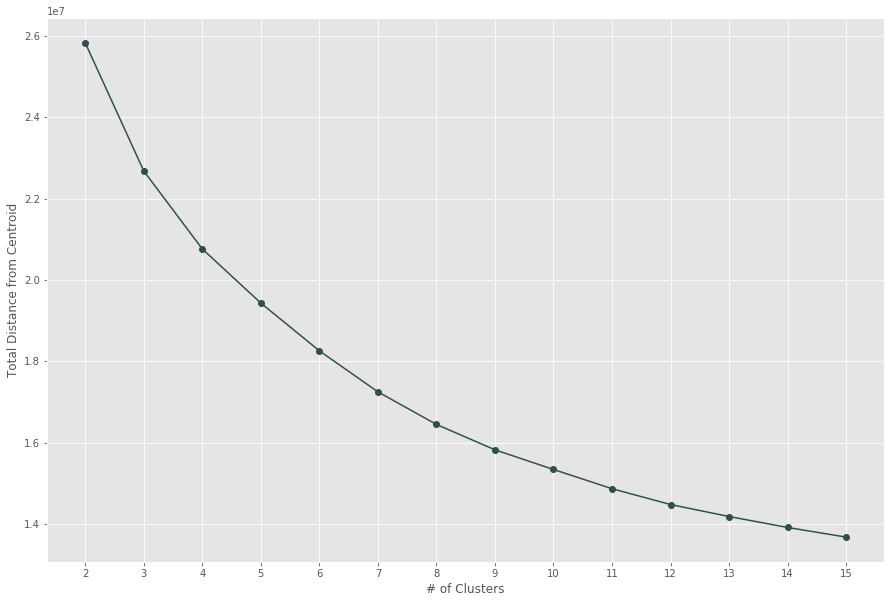

In [83]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Plot relationship plot
fig, ax = plt.subplots(figsize=(15,10))    
ax = pd.Series(score).plot(marker='o', color='darkslategray')
ax.set_xticks(np.arange(2, 16), minor=False);  
ax.set_xlabel("# of Clusters")
ax.set_ylabel("Total Distance from Centroid");   


In [84]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Final k=12
K=12
model_12 = KMeans(n_clusters=K, n_jobs=-1, random_state=0).fit(X_pca)
model_12.cluster_centers_.shape

(12, 12)

In [85]:
azdias_pred = model_12.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

The two closest elbow candidates are 8 and 12. At this point, I prefer to keep the cluster lower so 8 is the winner at this iteration and we'll see if we can come up with meaningful clustering using this number.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [86]:
# Load in the customer demographics data.
cust = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
cust.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  191652.000000         191652.000000  191652.000000  188439.000000   
mean        0.344359              3.060907       1.376432       3.677928   
std         1.391672              1.086254       0.484492       1.813975   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              3.000000       1.000000       2.000000   
50%         0.000000              3.000000       1.000000       4.000000   
75%         2.000000              4.000000       2.000000       6.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      191652.000000  191652.000000     191652.000000   191652.000000   
mean            3.963773       2.057051          4.183317        2.439808   
std             1.036230       1.319422          0.995365        1.697932   
min             1.000000       1.000000          1.000000        1.000000   
25%             3.000000       1.000000          3.000000        1.000000   
50%             4.000000       1.000000          5.000000        2.000000   
75%             5.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...           PLZ8_ANTG1  \
count          191652.000000     191652.000000      ...        138888.000000   
mean                2.646176          2.781176      ...             2.537404   
std                 1.586506          1.147353      ...             0.904927   
min                 1.000000          1.000000      ...             0.000000   
25%                 1.000000          2.000000      ...             2.000000   
50%                 2.000000          3.000000      ...             3.000000   
75%                 5.000000          3.000000      ...             3.000000   
max                 5.000000          5.000000      ...             4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  138888.000000  138888.000000  138888.000000  138888.000000   
mean        2.731510       1.388817       0.539939       1.556607   
std         0.840922       0.885038       0.637048       1.185736   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       1.000000       0.000000       1.000000   
75%         3.000000       2.000000       1.000000       1.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  138888.000000  138888.000000  141176.000000  141176.000000   
mean        3.634893       3.622192       2.824850       5.119517   
std         0.933660       1.008472       1.012415       2.159184   
min         1.000000       1.000000       1.000000       1.000000   
25%         3.000000       3.000000       2.000000       4.000000   
50%         3.000000       4.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

            RELAT_AB  
count  141176.000000  
mean        2.898510  
std         1.422683  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         4.000000  
max         9.000000  

[8 rows x 81 columns]

In [87]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

Load the dataset, OK
KK_KUNDENTYP        58.406382
KBA05_BAUMAX        29.209192
KBA05_ANTG4         29.209192
KBA05_ANTG3         29.209192
KBA05_ANTG2         29.209192
MOBI_REGIO          29.209192
KBA05_ANTG1         29.209192
KBA05_GBZ           29.209192
REGIOTYP            28.311732
KKK                 28.311732
W_KEIT_KIND_HH      28.041450
PLZ8_ANTG2          27.531150
PLZ8_ANTG1          27.531150
PLZ8_ANTG3          27.531150
PLZ8_ANTG4          27.531150
PLZ8_BAUMAX         27.531150
PLZ8_HHZ            27.531150
PLZ8_GBZ            27.531150
ANZ_HH_TITEL        27.189907
KBA13_ANZAHL_PKW    26.757352
dtype: float64
Number of rows that have no NaNs: 32
Total percentage of Nans: 13.83%
Converting missing data to NaN: Please wait. This can take a while.AGER_TYP NaNs before:  0
AGER_TYP NaNs after:  96738 

ALTERSKATEGORIE_GROB NaNs before:  0
ALTERSKATEGORIE_GROB NaNs after:  240 

ANREDE_KZ NaNs before:  0
ANREDE_KZ NaNs after:  0 

CJT_GESAMTTYP NaNs before:  3213
CJT_GESAM

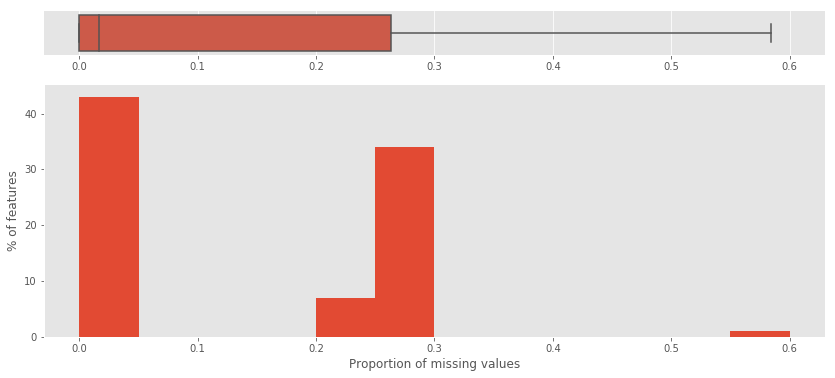

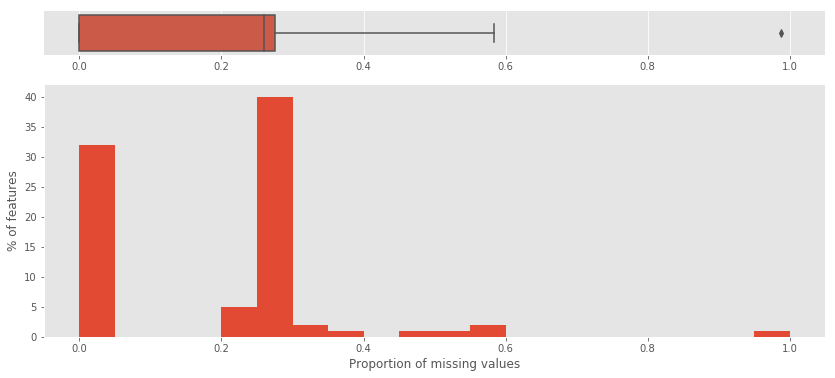

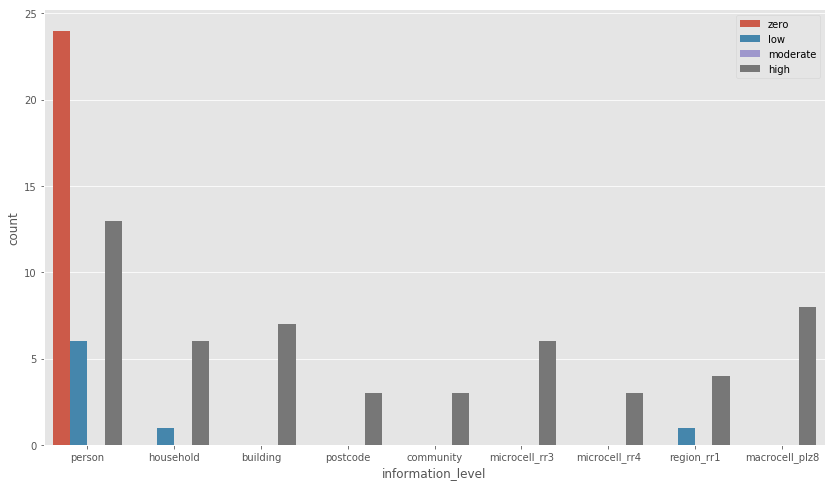

In [88]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
dc = DataCleaner(cust, feat_info, debug=False)
print('Load the dataset, OK')
df_cust, df_cust_high = dc.clean(debug=True)


In [89]:
# Feature transformation
# Fit the Scaler without NaNs
# feature transformation
# Apply the imputer with missing values in the full data using mean strategy
# Transform the df with the fitted scaler

df_cust_drop = df_cust.dropna(axis=0)
X_cust_scaled = ss.fit_transform(df_cust_drop)
X_cust_scaled.shape
# Check the distribution of the feature with the highest % of NaNs
# Look at the figures in the debug output above 

(185331, 26)

In [90]:
df_cust_drop.shape

(185331, 26)

In [91]:
# Dimensionality reduction
X_cust_pca = pca.fit_transform(X_cust_scaled)
X_cust_pca.shape

(185331, 12)

In [92]:
# Clustering
X_cust_pred = model_12.predict(X_cust_pca)

In [93]:
np.unique(X_cust_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [94]:
X_cust_pred.shape

(185331,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [95]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def compare_proportions(general, customers):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('General Population Clusters')
    sns.countplot(general, ax=ax1)

    ax2.set_title('Customer Data Clusters')
    sns.countplot(customers, ax=ax2)
    plt.show()


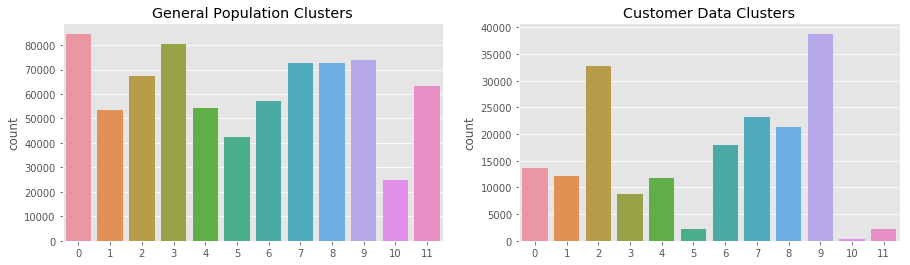

In [96]:

compare_proportions(azdias_pred, X_cust_pred)

In [129]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#cluster_9 = ss.inverse_transform(pca.inverse_transform(model_12.cluster_centers_[9]))
compPos9, compNeg9 = pcaToFeature(pca, df_cust_drop, 9)
print(compPos9, end="\n\n")
compNeg9

SEMIO_LUST               0.4366
SEMIO_TRADV              0.3953
SEMIO_ERL                0.3650
RETOURTYP_BK_S           0.2626
FINANZ_MINIMALIST        0.1468
SEMIO_RAT                0.1458
ALTERSKATEGORIE_GROB     0.1105
FINANZ_ANLEGER           0.1032
HH_EINKOMMEN_SCORE       0.0911
FINANZ_SPARER            0.0808
FINANZ_UNAUFFAELLIGER    0.0768
SEMIO_PFLICHT            0.0757
SEMIO_VERT               0.0389
SEMIO_KAEM               0.0292
SEMIO_FAM                0.0139
Name: 8, dtype: float64



FINANZ_HAUSBAUER    -0.3936
GREEN_AVANTGARDE    -0.3526
SEMIO_DOM           -0.1660
FINANZ_VORSORGER    -0.1453
SEMIO_SOZ           -0.1143
ONLINE_AFFINITAET   -0.1027
SEMIO_REL           -0.0641
SEMIO_KULT          -0.0176
SEMIO_KRIT          -0.0123
ANREDE_KZ           -0.0075
SEMIO_MAT           -0.0069
Name: 8, dtype: float64

In [124]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#cluster_11 = ss.inverse_transform(pca.inverse_transform(model_12.cluster_centers_[11]))
compPos11, compNeg11 = pcaToFeature(pca, df_cust_drop, 11)
print(compPos11, end="\n\n")
compNeg11

SEMIO_SOZ             0.5174
SEMIO_RAT             0.3317
SEMIO_PFLICHT         0.3089
SEMIO_LUST            0.2515
SEMIO_ERL             0.1770
FINANZ_MINIMALIST     0.1306
SEMIO_KULT            0.1246
SEMIO_REL             0.1197
FINANZ_VORSORGER      0.1102
SEMIO_DOM             0.0830
SEMIO_KAEM            0.0625
SEMIO_KRIT            0.0449
HH_EINKOMMEN_SCORE    0.0239
Name: 10, dtype: float64



SEMIO_TRADV             -0.5220
ALTERSKATEGORIE_GROB    -0.2241
GREEN_AVANTGARDE        -0.1357
FINANZ_HAUSBAUER        -0.0951
FINANZ_SPARER           -0.0655
RETOURTYP_BK_S          -0.0466
FINANZ_UNAUFFAELLIGER   -0.0424
FINANZ_ANLEGER          -0.0268
SEMIO_VERT              -0.0236
ANREDE_KZ               -0.0085
SEMIO_FAM               -0.0050
ONLINE_AFFINITAET       -0.0030
SEMIO_MAT               -0.0018
Name: 10, dtype: float64

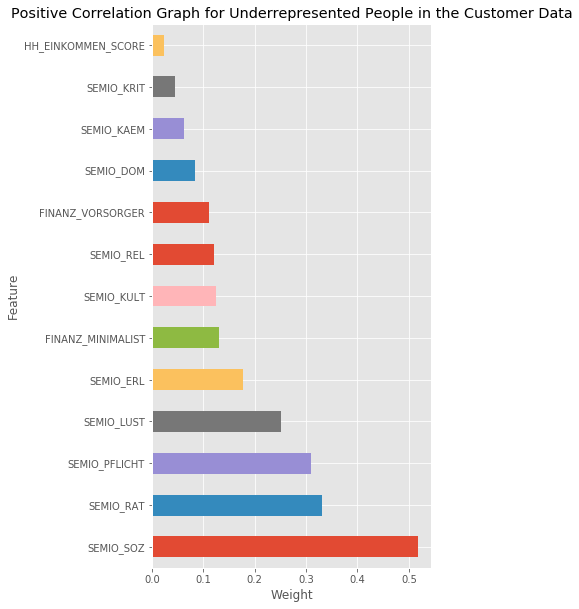

In [137]:
# let's grab the types of people that belongs on these two clusters (11, 9 and 3)

compPos11.plot.barh(figsize=(5,10))
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Positive Correlation Graph for Underrepresented People in the Customer Data')
plt.show()

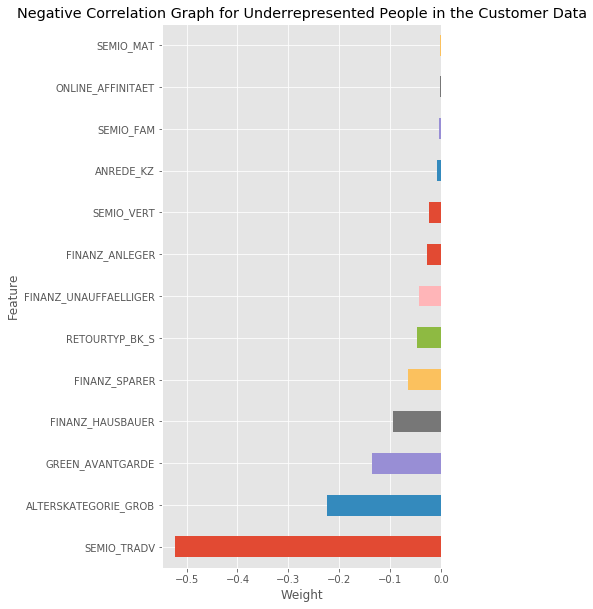

In [126]:
compNeg11.plot.barh(figsize=(5,10))
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Negative Correlation Graph for Underrepresented People in the Customer Data')
plt.show()

In [136]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#cluster_3 = ss.inverse_transform(pca.inverse_transform(model_12.cluster_centers_[3]))
compPos3, compNeg3 = pcaToFeature(pca, df_cust_drop, 3)
print(compPos3, end="\n\n")
compNeg3

FINANZ_HAUSBAUER        0.4528
HH_EINKOMMEN_SCORE      0.4183
RETOURTYP_BK_S          0.2255
SEMIO_FAM               0.2067
SEMIO_MAT               0.1578
SEMIO_LUST              0.1347
SEMIO_REL               0.1033
SEMIO_KULT              0.0969
SEMIO_SOZ               0.0523
FINANZ_VORSORGER        0.0471
SEMIO_VERT              0.0369
FINANZ_SPARER           0.0111
ALTERSKATEGORIE_GROB    0.0094
Name: 2, dtype: float64



ONLINE_AFFINITAET       -0.3795
GREEN_AVANTGARDE        -0.3416
FINANZ_MINIMALIST       -0.3096
ANREDE_KZ               -0.1596
SEMIO_DOM               -0.1456
SEMIO_ERL               -0.1283
SEMIO_KAEM              -0.1233
SEMIO_RAT               -0.1150
SEMIO_TRADV             -0.0754
SEMIO_KRIT              -0.0423
SEMIO_PFLICHT           -0.0268
FINANZ_ANLEGER          -0.0153
FINANZ_UNAUFFAELLIGER   -0.0148
Name: 2, dtype: float64

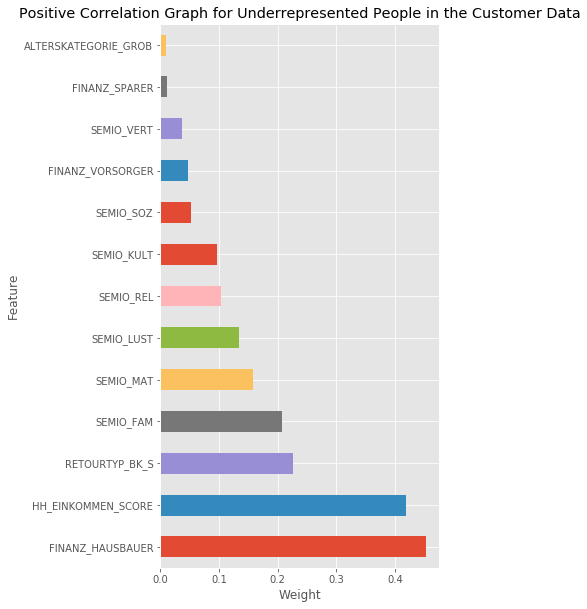

In [138]:
compPos3.plot.barh(figsize=(5,10))
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Positive Correlation Graph for Underrepresented People in the Customer Data')
plt.show()

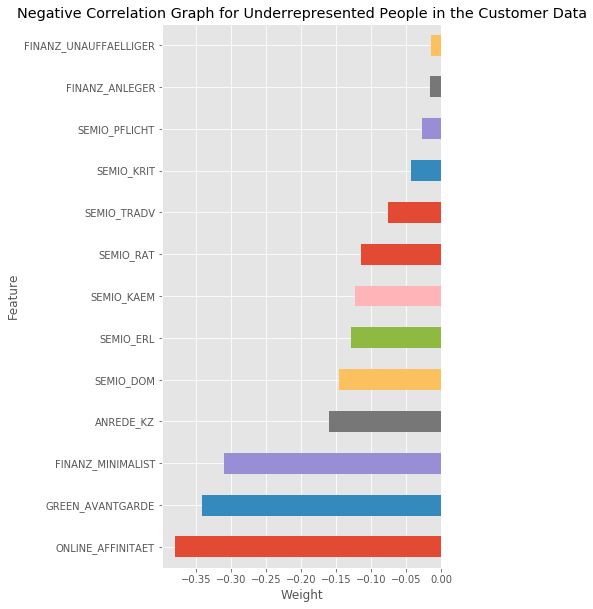

In [139]:
compNeg3.plot.barh(figsize=(5,10))
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Negative Correlation Graph for Underrepresented People in the Customer Data')
plt.show()

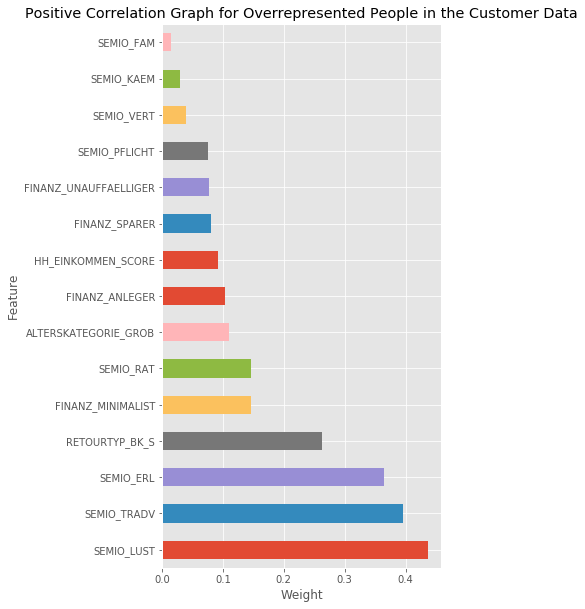

In [127]:
compPos9.plot.barh(figsize=(5,10))
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Positive Correlation Graph for Overrepresented People in the Customer Data')
plt.show()

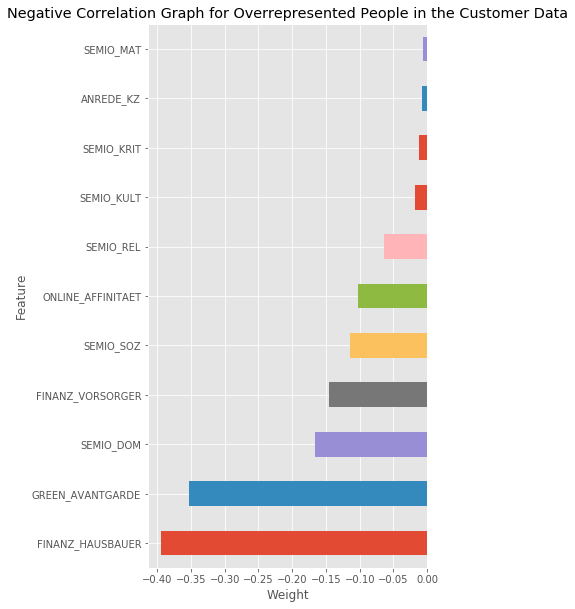

In [128]:
compNeg9.plot.barh(figsize=(5,10))
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Negative Correlation Graph for Overrepresented People in the Customer Data')
plt.show()

### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 9 is overrepresented in the customer data with respect to the general population. The top 5 features of this cluster that has the highest weights are:
* SEMIO_LUST (sensual-minded)               0.4366
* SEMIO_TRADV  (traditional-minded)            0.3953
* SEMIO_ERL    (event-oriented)            0.3650
* RETOURTYP_BK_S           0.2626
* FINANZ_MINIMALIST (low financial interest)       0.1468

On the other hand, cluster 3, as well as clusters 11, and 0, are underrepresented in the customer data. The top 5 characteristics of this cluster 3 are:
* FINANZ_HAUSBAUER (home owners)        0.4528
* HH_EINKOMMEN_SCORE      0.4183
* RETOURTYP_BK_S          0.2255
* SEMIO_FAM  (family-minded)             0.2067
* SEMIO_MAT   (materialistic)            0.1578


Top 5 for cluster 11:
* SEMIO_SOZ (socially-minded)            0.5174
* SEMIO_RAT  (rational)           0.3317
* SEMIO_PFLICHT (dutiful)        0.3089
* SEMIO_LUST (sensual-minded)            0.2515
* SEMIO_ERL   (event-oriented)          0.1770


In [134]:
cat_md_file()

# Data Dictionary for Identify Customer Segments Data



## Introduction



The data for this project consist of two files:



- Udacity_AZDIAS_Subset.csv: demographics data for the general population of

      Germany; 891211 persons (rows) x 85 features (columns)

- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order

      company; 191652 persons (rows) x 85 features (columns)



The columns in the general demographics file and customers data file are the

same. This file documents the features that appear in the data files, sorted in

order of appearance. Sections of this file is based on the level of measurement

of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of

feature attributes, including information level, data type, and codes for

missing or unknown values.



### Table of Contents



 1. Person-level features

 2. Household-level features

 3. Building-level features

 4. RR4 micro-cell features

 5. RR3 micro-cell featur

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.